# Load data

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import read_data
from scopus import get_affiliation_details, affiliation_scopus_details


data_dir = 'data'
results_dir = 'results'np
figures_dir = f'{results_dir}/figures'


def load_author_data(data_dir):
    author_data = {}
    for affiliation in os.listdir(data_dir):
        affiliation_path = os.path.join(data_dir, affiliation)
        if os.path.isdir(affiliation_path):
            author_data[affiliation] = []
            for author_file in os.listdir(affiliation_path):
                if author_file.endswith('.json'):
                    author_path = os.path.join(affiliation_path, author_file)
                    author_data[affiliation].append(read_data(author_path))  # Replace with your read_data function
    return author_data


def load_institution_data(data_dir):
    return read_data(f'{data_dir}/affiliations.json')


author_data = load_author_data(data_dir)
institution_data = load_institution_data(data_dir)

### Top 10 affiliations listed by the universities top researchers
* We notice that Scopus sometimes identifies the School or Hospital of the author as the affiliation, instead of the University or Institution.
* All these schools and hospitals were identified and added to the list of affiliations for the university.
* We include foreign campus of the university such as `Monash University Malaysia`. However, we exclude institutions which are a joint venture with another university such as `Southeast University-Monash University Suzhou Joint Graduate School`.

In [28]:
def get_top_internal_affiliations(author_data, limit=10, save=False):
    top_affiliations = {}
    for affiliation, authors in author_data.items():
        top_affiliations[affiliation] = {}
        for author in authors:
            scopus_id = author['affiliation_id']
            if not scopus_id or scopus_id not in affiliation_scopus_details:
                continue
            elif scopus_id in top_affiliations[affiliation]:
                top_affiliations[affiliation][scopus_id] += 1
            else:
                top_affiliations[affiliation][scopus_id] = 1

        top_affiliations[affiliation] = dict(sorted(top_affiliations[affiliation].items(), key=lambda x: x[1], reverse=True)[:limit])

    if save:
        # Store in a file called `top_researcher_affiliation_per_university.txt`
        with open(f'{data_dir}/top_researcher_affiliation_per_university.txt', 'w') as f:
            for affiliation, affiliations in top_affiliations.items():
                f.write(f'Top affiliations for {affiliation}:\n')
                for affiliation_id, count in affiliations.items():
                    affiliation_details = get_affiliation_details(affiliation_id)
                    f.write(f'{affiliation_details["name"]}: {count}\n')
                f.write('\n')

    return top_affiliations

top_affiliations = get_top_internal_affiliations(author_data, save=True)

### Find top 1000 collaborating institutions for each university

In [ ]:
def get_top_collaborators(author_data, limit=200, show_details=False):
    collaborators = dict()
    for affiliation, authors in author_data.items():
        collaborators[affiliation] = dict()
        for author in authors:
            for pub in author['publications']:
                for coauthor in pub['authors']:
                    # A co-author can have multiple affiliations
                    # Each affiliation is a potential collaborator and included
                    # with a normalised contribution
                    coauthor_affiliations = coauthor['affiliation_id']
                    for coauthor_affiliation in coauthor_affiliations:
                        if coauthor_affiliation in collaborators[affiliation]:
                            collaborators[affiliation][coauthor_affiliation] += 1 / len(coauthor_affiliations)
                        else:
                            collaborators[affiliation][coauthor_affiliation] = 1 / len(coauthor_affiliations)

    # Sort the collaborators for each university based ond documents
    top_collaborators = dict()
    for affiliation, collaborator_data in collaborators.items():
        if not show_details:
            top_collaborators[affiliation] = {
                affiliation_id: count for affiliation_id, count in sorted(collaborator_data.items(), key=lambda x: x[1], reverse=True)[:limit]
            }
        else:
            top_collaborators[affiliation] = dict()
            for affiliation_id, count in sorted(collaborator_data.items(), key=lambda x: x[1], reverse=True)[:limit]:
                affiliation_details = get_affiliation_details(affiliation_id)
                top_collaborators[affiliation][affiliation_id] = {
                    'name': affiliation_details['name'],
                    'document-count': count, # normalised for multiple affiliations
                    'city': affiliation_details['city'],
                    'country': affiliation_details['country']
                }
    return top_collaborators

top_collaborators = get_top_collaborators(author_data, limit=1000, show_details=True)

### Display Top 10 collaborators

In [ ]:
from IPython.display import display

# Only display the top 10 for each university
for affiliation, collaborators in top_collaborators.items():
    print(affiliation)
    top_10 = dict(sorted(collaborators.items(), key=lambda x: x[1]['document-count'], reverse=True)[:10])
    collab_df = pd.DataFrame(collaborators)
    display(collab_df)
    print()

## Plots

### Citations

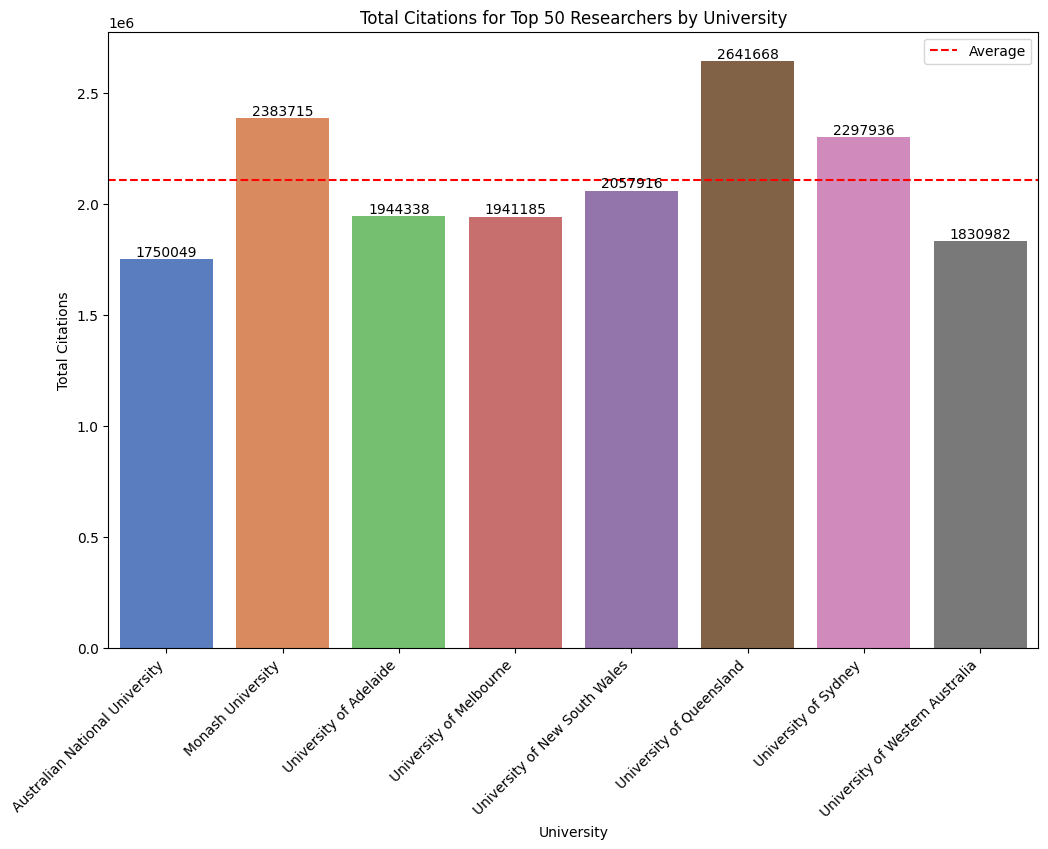

In [6]:
def plot_citations_by_university(author_data, save=None):
    citations_data = list()
    universities = list()
    for affiliation, authors in author_data.items():
        universities.append(affiliation)
        citations_data.append(0)
        for author in authors:
            citations_data[-1] += sum(pub['citations'] for pub in author['publications'])

    # Sort x and y values by x
    universities, citations_data = zip(*sorted(zip(universities, citations_data), key=lambda x: x[0]))

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=universities, y=citations_data, hue=universities, palette='muted', legend=False)
    plt.xlabel('University')
    plt.ylabel('Total Citations')
    plt.title(f'Total Citations for Top {len(authors)} Researchers by University')
    plt.xticks(rotation=45, ha='right')

    # Remove horizontal gridlines
    ax.yaxis.grid(False)

    # Put numbers on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    # Plot average as a line
    average_citations = sum(citations_data) / len(citations_data)
    plt.axhline(average_citations, color='red', linestyle='--', label='Average')
    plt.legend() # Show legend

    if save:
        plt.savefig(save)  # Save plot as PNG

    plt.show()

plot_citations_by_university(author_data, save=f'{figures_dir}/citations_by_university.png')

### Subject areas

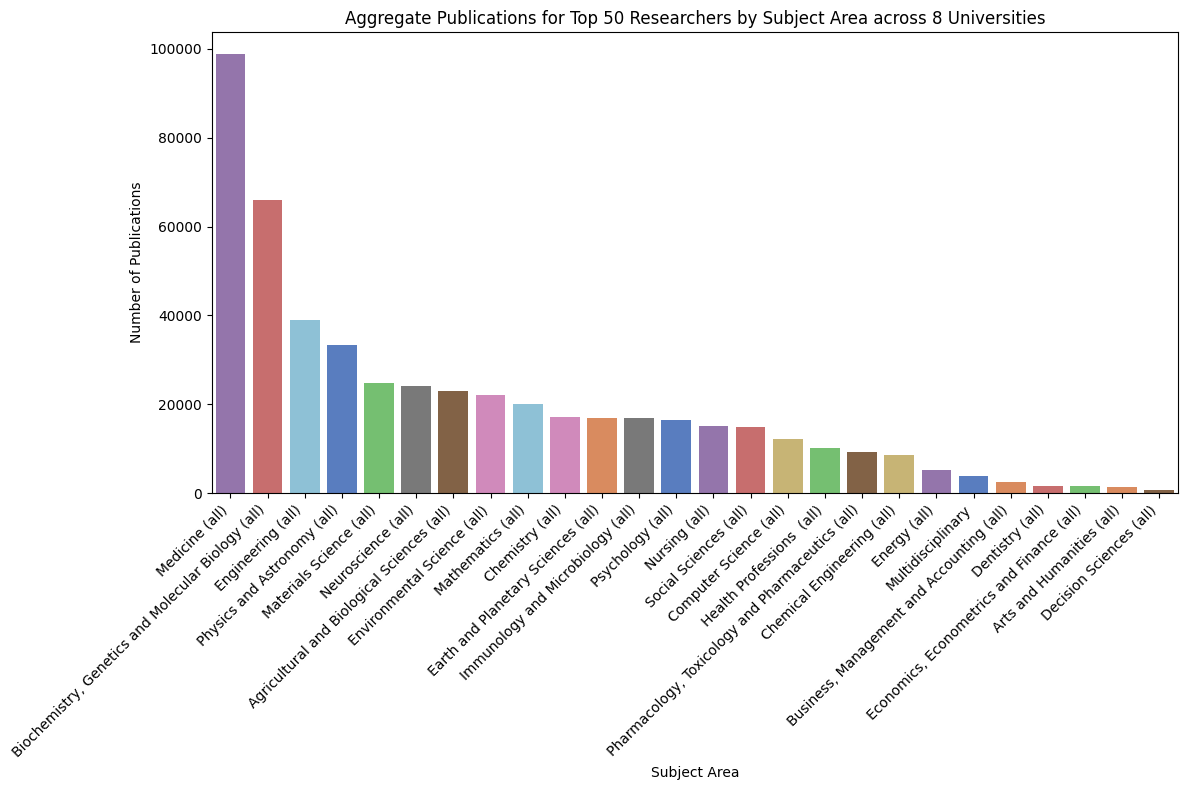

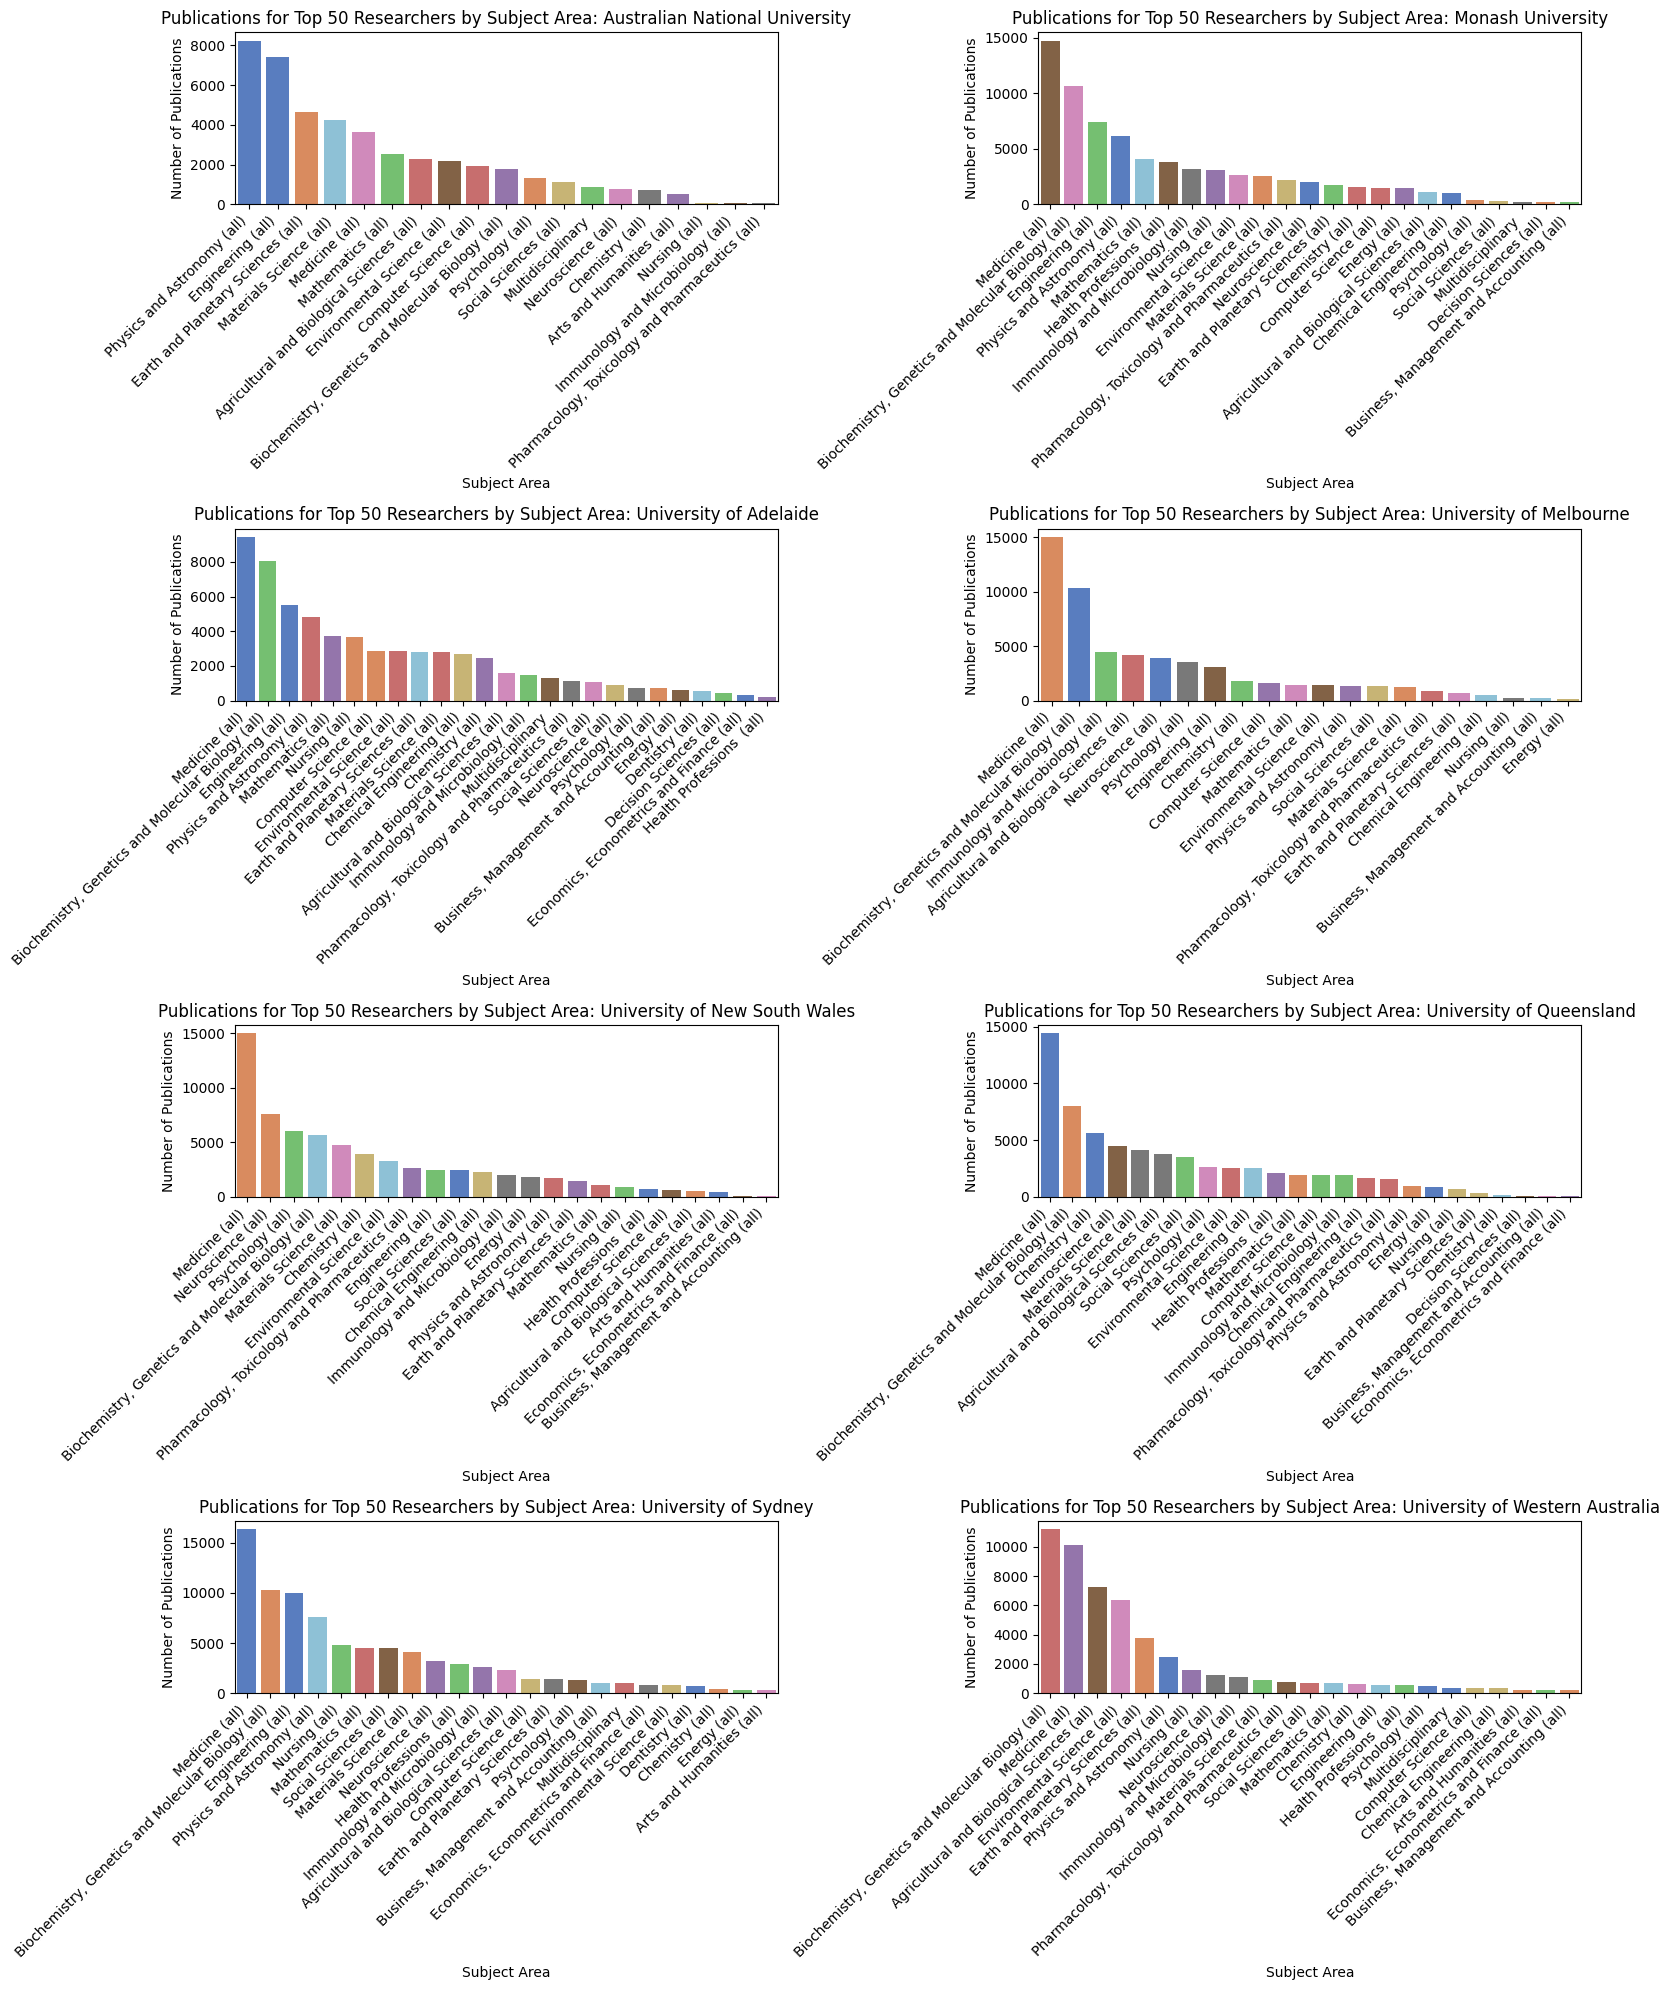

In [10]:
def plot_publications_by_subject_area(author_data, save=None):
    def publications_by_subject_area(author_data, university):
        return pd.DataFrame([{'University': university, 'Subject Area': subject['$'], 'Publication Count': 1}
                             for author in author_data[university]
                             for pub in author['publications']
                             for subject in author['subject_area']])

    universities = list(author_data.keys())[:8]
    aggregate_df = pd.concat([publications_by_subject_area(author_data, university) for university in universities])

    subject_counts_all = aggregate_df.groupby('Subject Area')['Publication Count'].sum().sort_values(ascending=False)
    sorted_subjects_all = subject_counts_all.index.tolist()

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Subject Area', y='Publication Count', hue='Subject Area', data=aggregate_df,
                estimator=np.sum, palette='muted', order=sorted_subjects_all)
    plt.xlabel('Subject Area')
    plt.ylabel('Number of Publications')
    plt.title(f'Aggregate Publications for Top {len(list(author_data.values())[0])} Researchers by Subject Area across 8 Universities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save:
        save_as = f'{save.rsplit("/", 1)[0]}/aggregate_{save.rsplit("/", 1)[-1]}'
        plt.savefig(save_as)  # Save plot as PNG
    plt.show()

    plt.figure(figsize=(16, 20))

    # Sort universities alphabetically
    universities.sort()

    for i, university in enumerate(universities):
        plt.subplot(4, 2, i+1)
        publications_df = publications_by_subject_area(author_data, university)

        subject_counts = publications_df.groupby('Subject Area')['Publication Count'].sum().sort_values(ascending=False)
        sorted_subjects = subject_counts.index.tolist()

        sns.barplot(x='Subject Area', y='Publication Count', hue='Subject Area', data=publications_df,
                    estimator=np.sum, palette='muted', ax=plt.gca(), order=sorted_subjects)
        plt.xlabel('Subject Area')
        plt.ylabel('Number of Publications')
        plt.title(f'Publications for Top {len(list(author_data.values())[0])} Researchers by Subject Area: {university}')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    if save:
        plt.savefig(save)  # Save plot as PNG

    plt.show()

plot_publications_by_subject_area(author_data, save=f'{figures_dir}/publications_by_subject_area.png')

### Collaboration network

In [ ]:
# Create a function to plot column chart of the collaborators published by university
# with three legends: Internal (same university), Domestic (same country), and International (other countries)
# There will be some records for which affiliation details are not available just skip them

def plot_collaborators_by_university(institution_data, author_data, top_collaborators, save=None):
    def get_collaborator_category(affiliation_id, affiliation):
        if affiliation_id in institution_data[affiliation]['scopus_id']:
            return 'Internal'
        elif affiliation_id in affiliation_scopus_details:
            if affiliation_scopus_details[affiliation_id]['country'] == institution_data[affiliation_id]['country']:
                return 'Domestic'
            else:
                return 'International'
        else:
            return None

    collaborator_data = list()
    universities = list()
    for affiliation, authors in author_data.items():
        universities.append(affiliation)
        internal_collaborators = 0
        domestic_collaborators = 0
        international_collaborators = 0
        for author in authors:
            for pub in author['publications']:
                for coauthor in pub['authors']:
                    category = get_collaborator_category(coauthor['affiliation_id'], top_collaborators[affiliation])
                    if category == 'Internal':
                        internal_collaborators += 1
                    elif category == 'Domestic':
                        domestic_collaborators += 1
                    elif category == 'International':
                        international_collaborators += 1

        collaborator_data.append({
            'University': affiliation,
            'Internal Collaborators': internal_collaborators,
            'Domestic Collaborators': domestic_collaborators,
            'International Collaborators': international_collaborators
        })

    collaborator_df = pd.DataFrame(collaborator_data)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='University', y='Internal Collaborators', data=collaborator_df, color='b', label='Internal')
    sns.barplot(x='University', y='Domestic Collaborators', data=collaborator_df, color='g', label='Domestic')
    sns.barplot(x='University', y='International Collaborators', data=collaborator_df, color='r', label='International')
    plt.xlabel('University')
    plt.ylabel('Number of Collaborators')
    plt.title(f'Collaborators for Top {len(list(author_data.values())[0])} Researchers by University')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    if save:
        plt.savefig(save)  # Save plot as PNG

    plt.show()

plot_collaborators_by_university(institution_data, author_data, top_collaborators, save=f'{figures_dir}/collaborators_by_university.png')

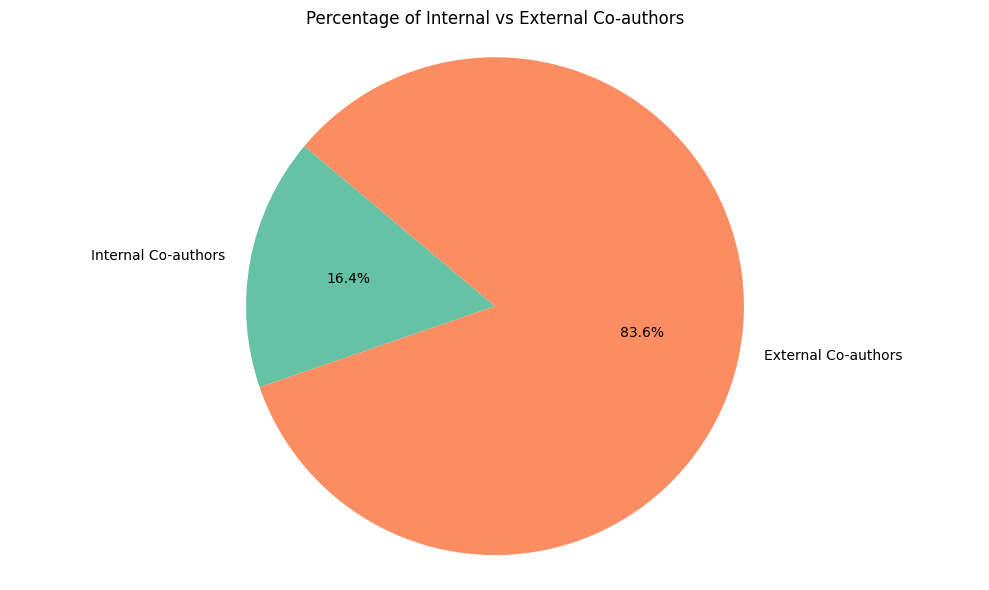

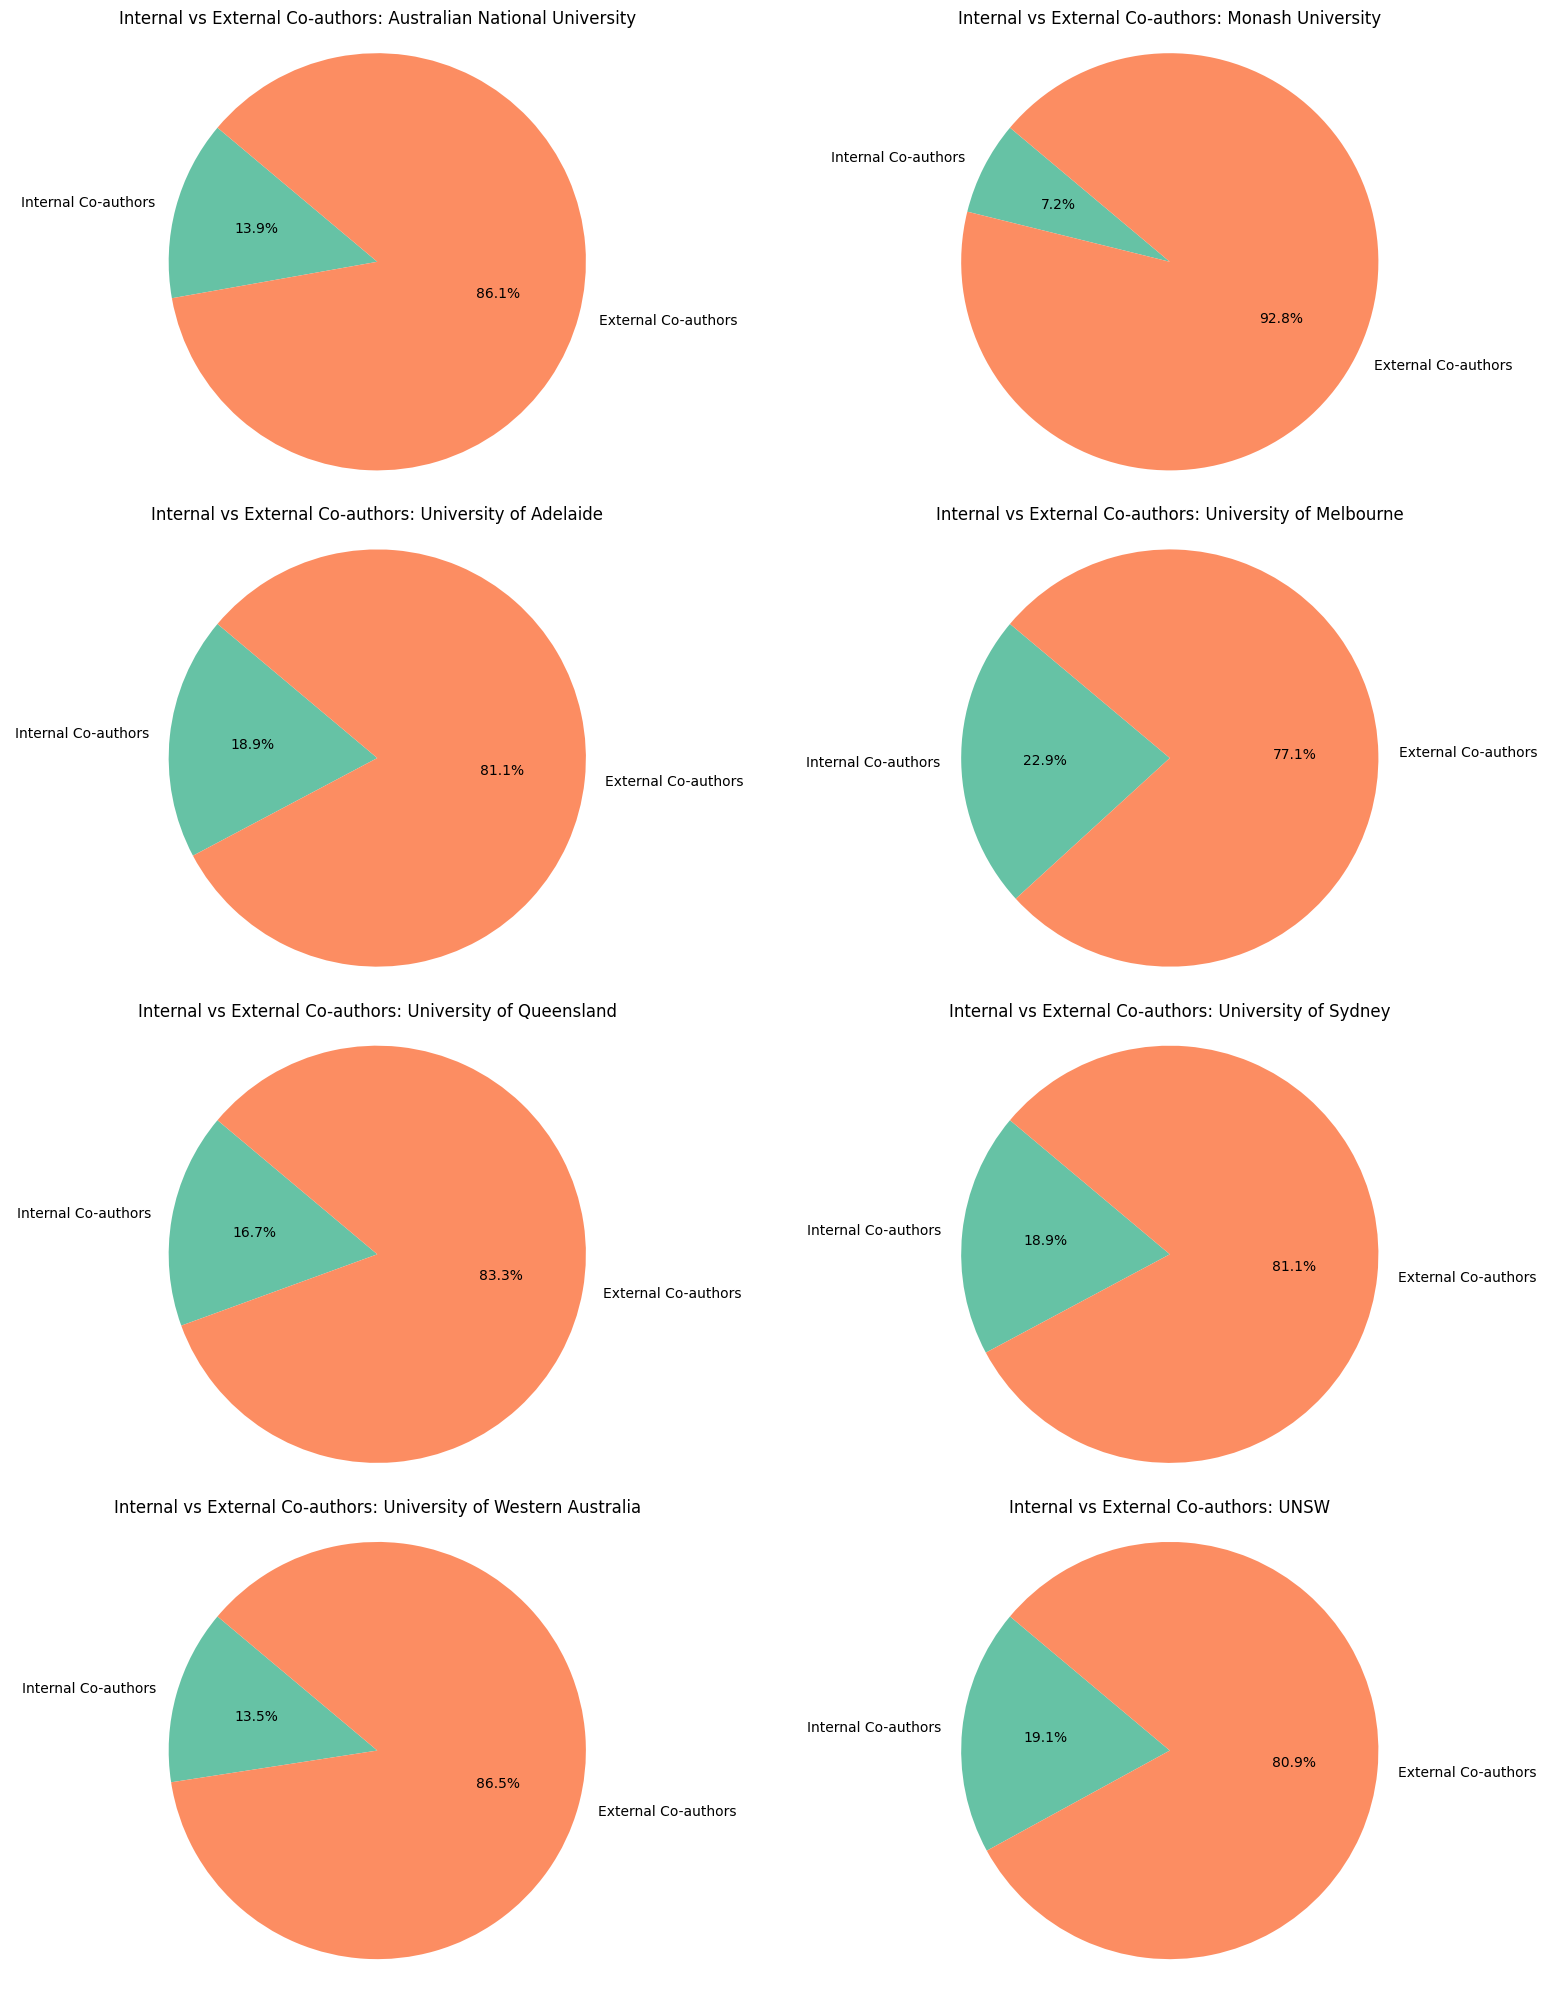

In [3]:
def plot_internal_vs_external_coauthors(author_data, save=None):

    def internal_vs_external_coauthors(author_data):
        coauthors_data = []
        for affiliation, authors in author_data.items():
            affiliation_set = set(institution_data[affiliation]['scopus_id'])
            for author in authors:
                internal_count = 0
                external_count = 0
                for pub in author['publications']:
                    for coauthor in pub['authors']:
                        coauthor_affiliation_set = set(coauthor['affiliation_id'])
                        if affiliation_set & coauthor_affiliation_set:
                            internal_count += 1
                        else:
                            external_count += 1
                total_coauthors = internal_count + external_count
                if total_coauthors > 0:
                    coauthors_data.append({
                        'University': affiliation,
                        'Internal Co-authors (%)': (internal_count / total_coauthors) * 100,
                        'External Co-authors (%)': (external_count / total_coauthors) * 100
                    })
        coauthors_df = pd.DataFrame(coauthors_data)
        return coauthors_df

    coauthors_df = internal_vs_external_coauthors(author_data)

    # Plotting using Matplotlib (pie chart)
    plt.figure(figsize=(10, 6))
    labels = ['Internal Co-authors', 'External Co-authors']
    colors = ['#66c2a5', '#fc8d62']
    plt.pie(coauthors_df[['Internal Co-authors (%)', 'External Co-authors (%)']].sum(), labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(f'Percentage of Internal vs External Co-authors')
    plt.axis('equal')
    plt.tight_layout()
    if save:
        save_as = f'{save.rsplit("/", 1)[0]}/aggregate_{save.rsplit("/", 1)[-1]}'
        plt.savefig(save_as)  # Save plot as PNG
    plt.show()

    # Function to calculate internal vs external co-authors
    universities = coauthors_df['University'].unique()

    plt.figure(figsize=(16, 20))
    for i, university in enumerate(universities):
        plt.subplot(4, 2, i+1)
        university_data = coauthors_df[coauthors_df['University'] == university]

        plt.pie(university_data[['Internal Co-authors (%)', 'External Co-authors (%)']].sum(), labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
        plt.title(f'Internal vs External Co-authors: {university}')
        plt.axis('equal')

    plt.tight_layout()
    if save:
        plt.savefig(save)  # Save plot as PNG
    plt.show()

plot_internal_vs_external_coauthors(author_data, save=f'{figures_dir}/internal_vs_external_coauthors.png')

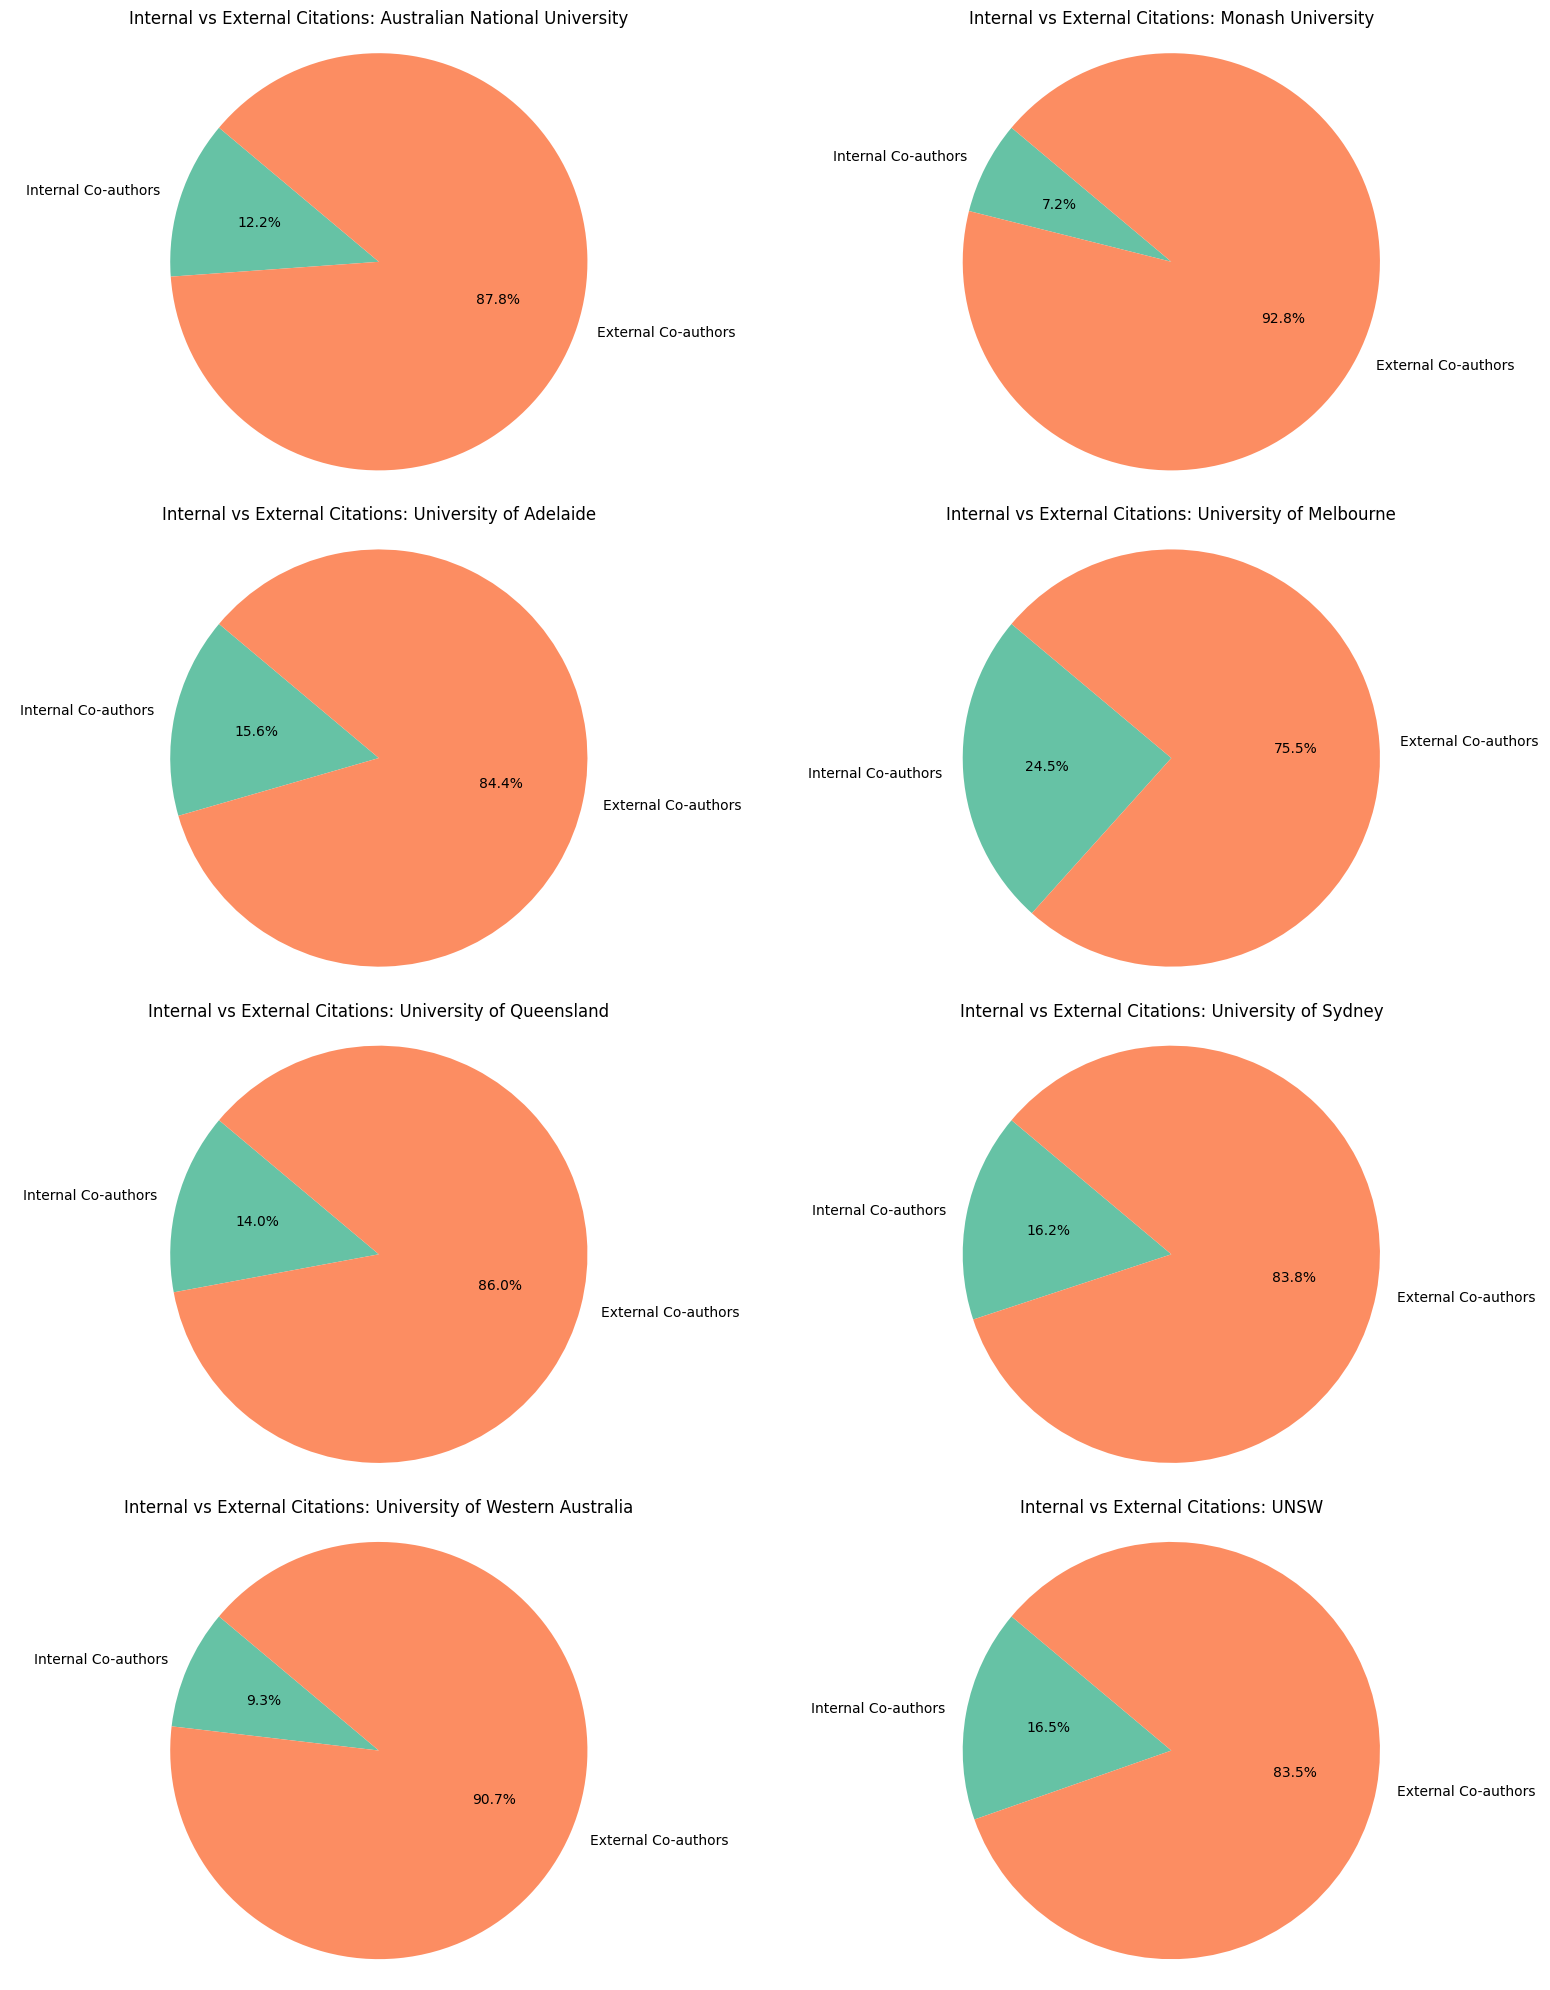

In [11]:
def internal_vs_external_citations(author_data, institution_data, save=None):
    def get_internal_external_citations(author_data, university):
        internal_citations = 0
        external_citations = 0
        affiliation_set = set(institution_data[university]['scopus_id'])
        for author in author_data[university]:
            for pub in author['publications']:
                total_citations = pub['citations']
                internal_citations += total_citations
                for coauthor in pub['authors']:
                    coauthor_affiliation_set = set(coauthor['affiliation_id'])
                    if not (affiliation_set & coauthor_affiliation_set):
                        internal_citations -= total_citations / len(pub['authors'])
                        external_citations += total_citations / len(pub['authors'])
        return internal_citations, external_citations

    universities = list(author_data.keys())

    plt.figure(figsize=(16, 20))
    for i, university in enumerate(universities):
        plt.subplot(4, 2, i+1)
        internal_citations, external_citations = get_internal_external_citations(author_data, university)

        labels = ['Internal Co-authors', 'External Co-authors']
        colors = ['#66c2a5', '#fc8d62']
        plt.pie([internal_citations, external_citations], labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
        plt.title(f'Internal vs External Citations: {university}')
        plt.axis('equal')

    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig(save)

internal_vs_external_citations(author_data, institution_data) 

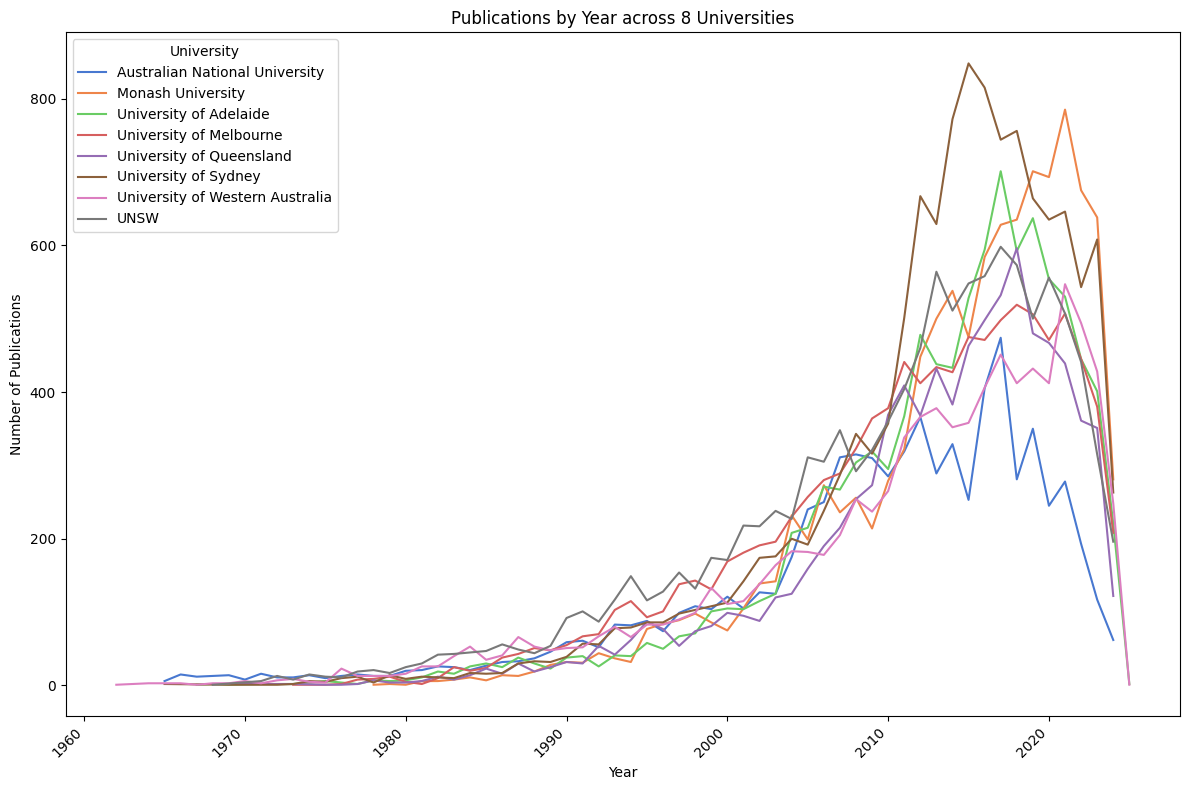

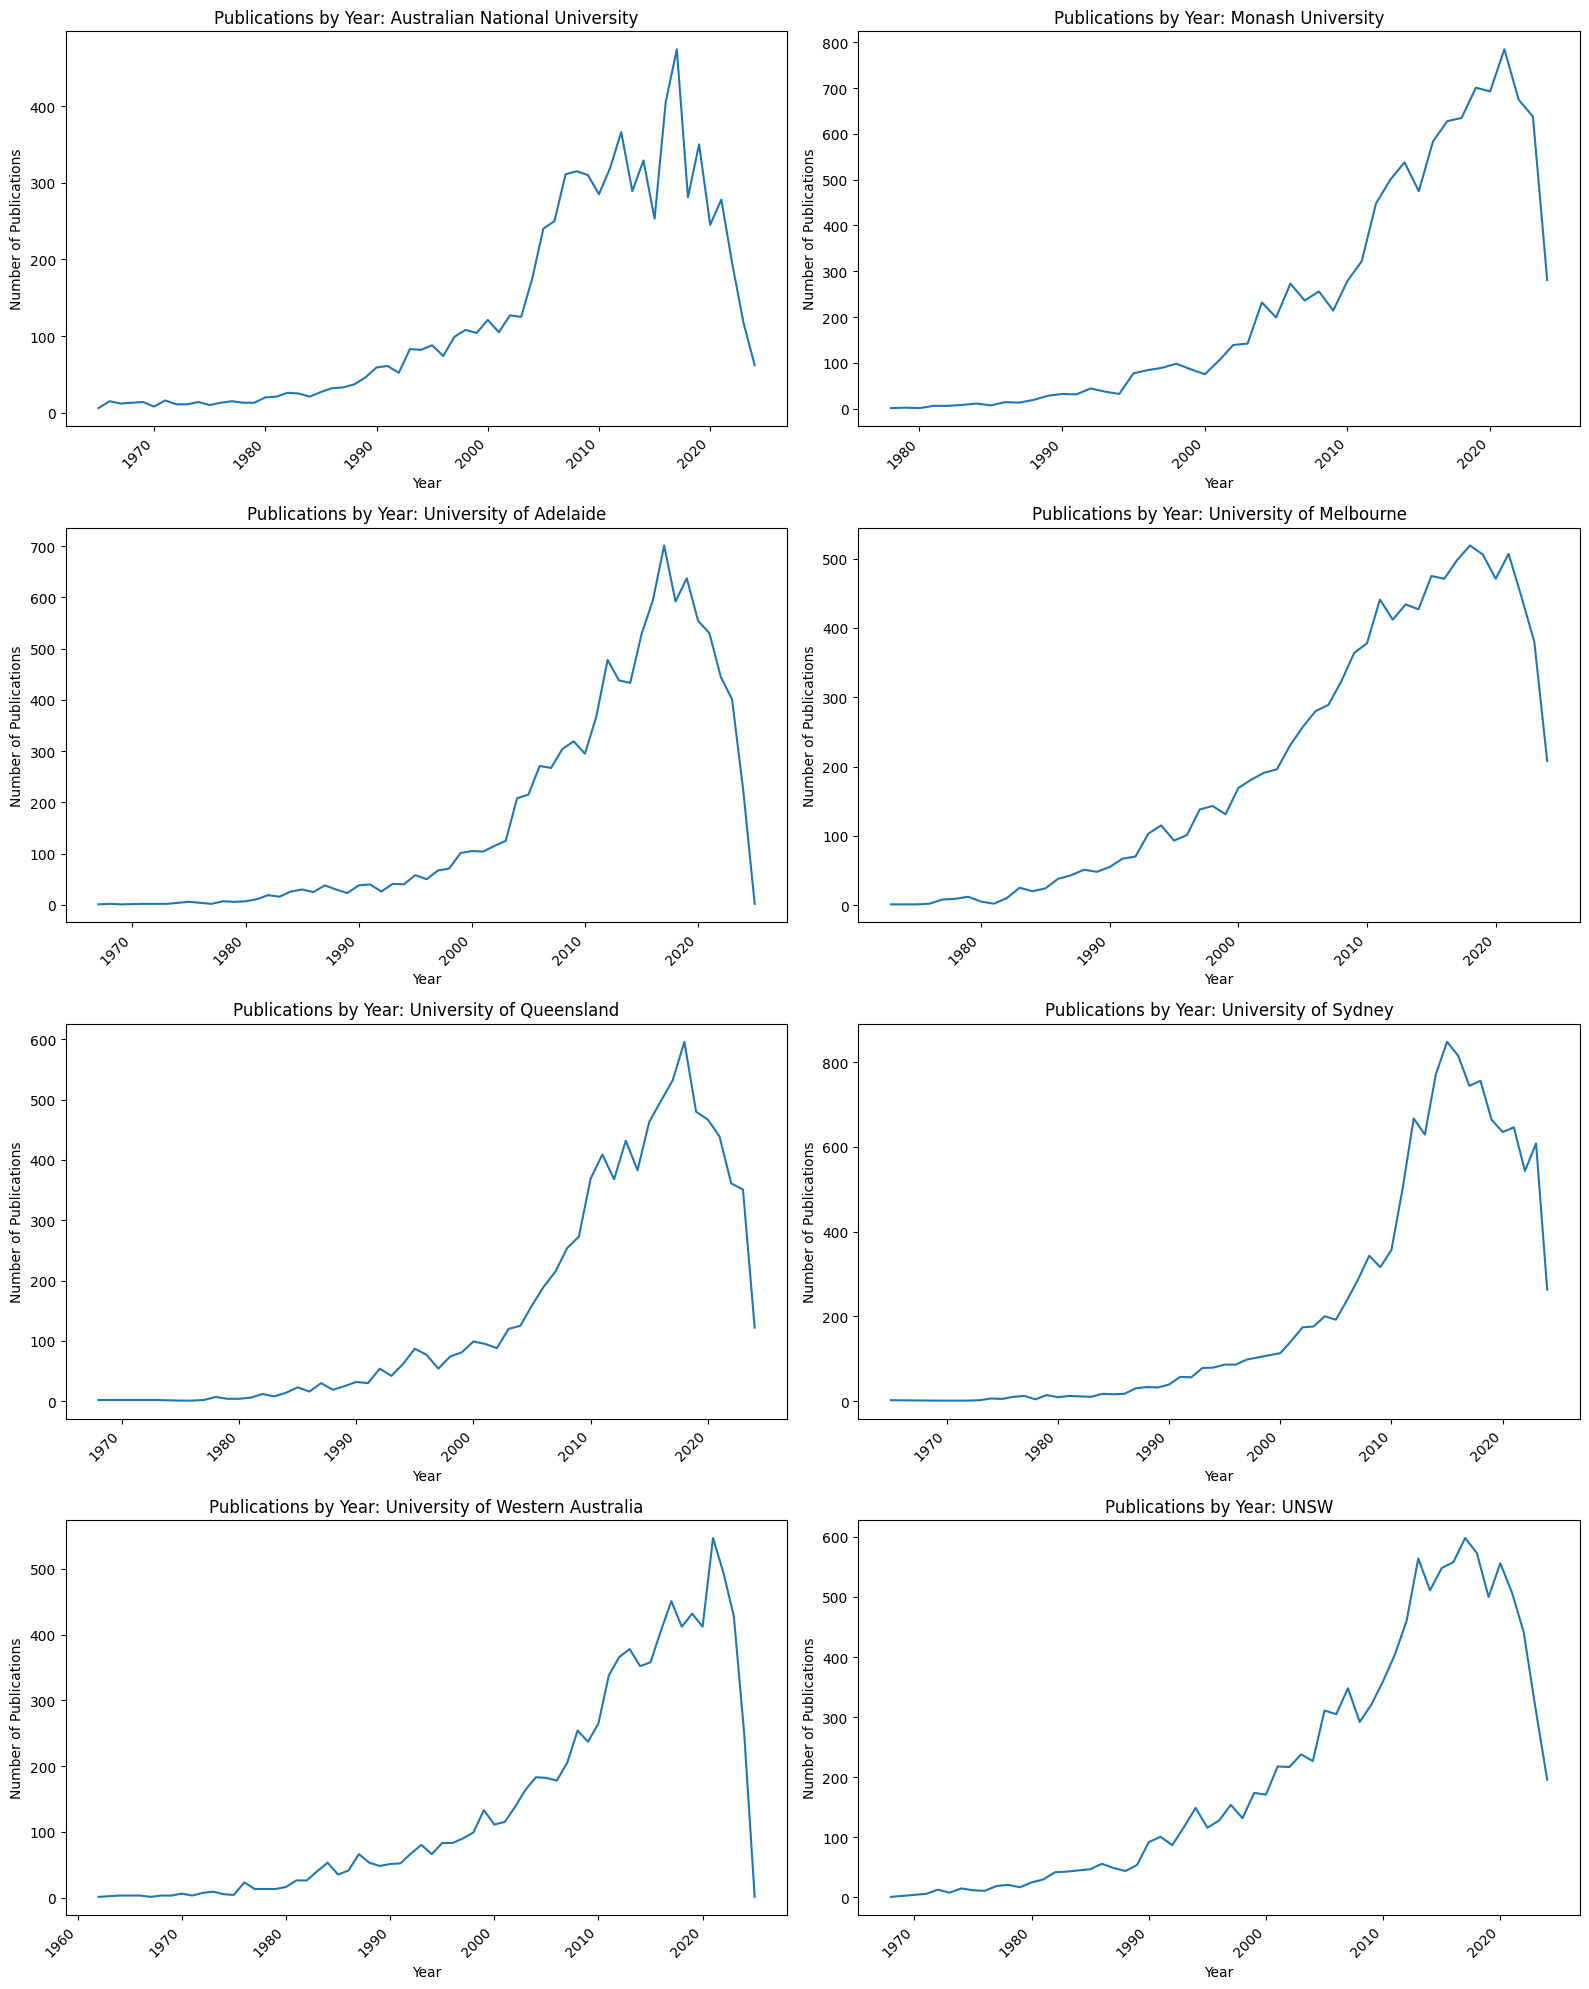

In [27]:
def publications_over_time(author_data, save=None, exclude_years=[]):
    def publications_by_year(author_data, university):
        publications = []
        for author in author_data[university]:
            for pub in author['publications']:
                year = int(pub['cover_date'].split('-')[0])
                if year in exclude_years:
                    continue
                publications.append({'University': university, 'Year': year, 'Publication Count': 1})

        df = pd.DataFrame(publications)
        df = df.groupby(['University', 'Year']).sum().reset_index().sort_values(['University', 'Year'])
        return df

    universities = list(author_data.keys())[:8]
    aggregate_df = pd.concat([publications_by_year(author_data, university) for university in universities])

    plt.figure(figsize=(12, 8))
    sns.lineplot(x='Year', y='Publication Count', hue='University', data=aggregate_df, palette='muted')
    plt.xlabel('Year')
    plt.ylabel('Number of Publications')
    plt.title('Publications by Year across 8 Universities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 20))
    for i, university in enumerate(universities):
        plt.subplot(4, 2, i+1)
        publications_df = publications_by_year(author_data, university)

        sns.lineplot(x='Year', y='Publication Count', data=publications_df, ax=plt.gca())
        plt.xlabel('Year')
        plt.ylabel('Number of Publications')
        plt.title(f'Publications by Year: {university}')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig(save)

publications_over_time(author_data)

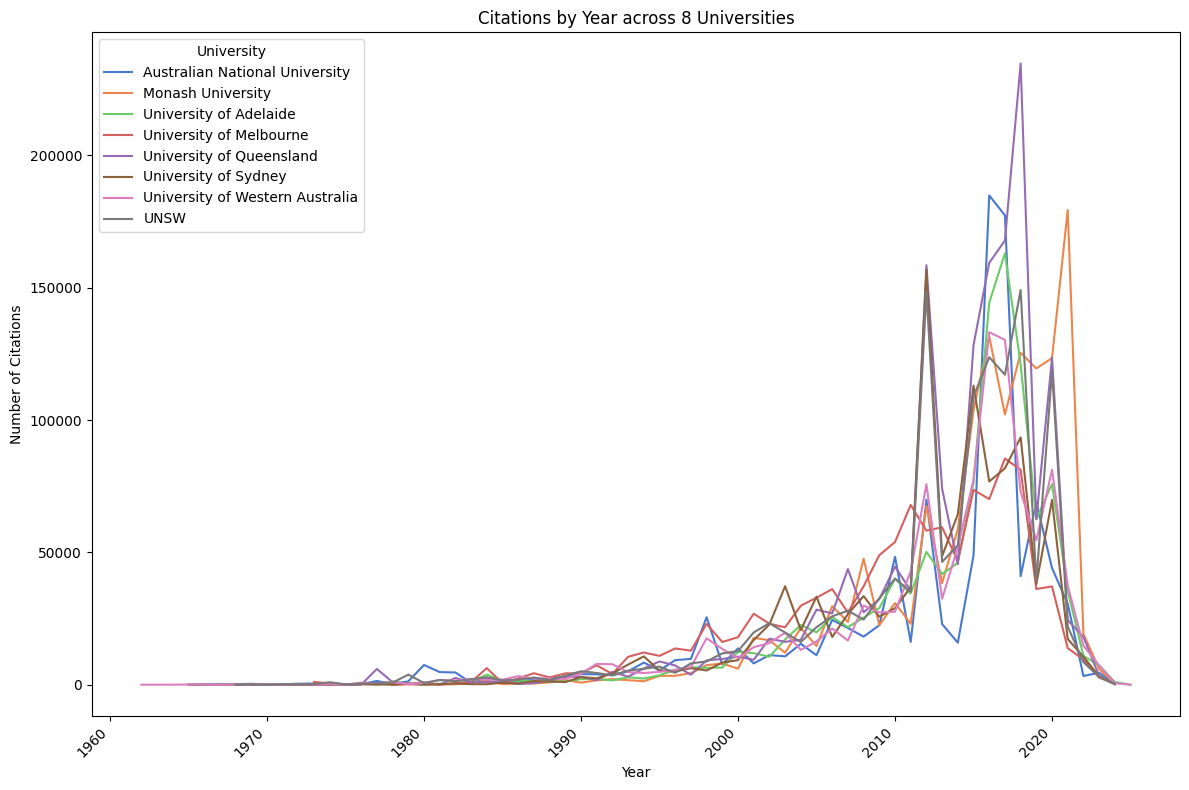

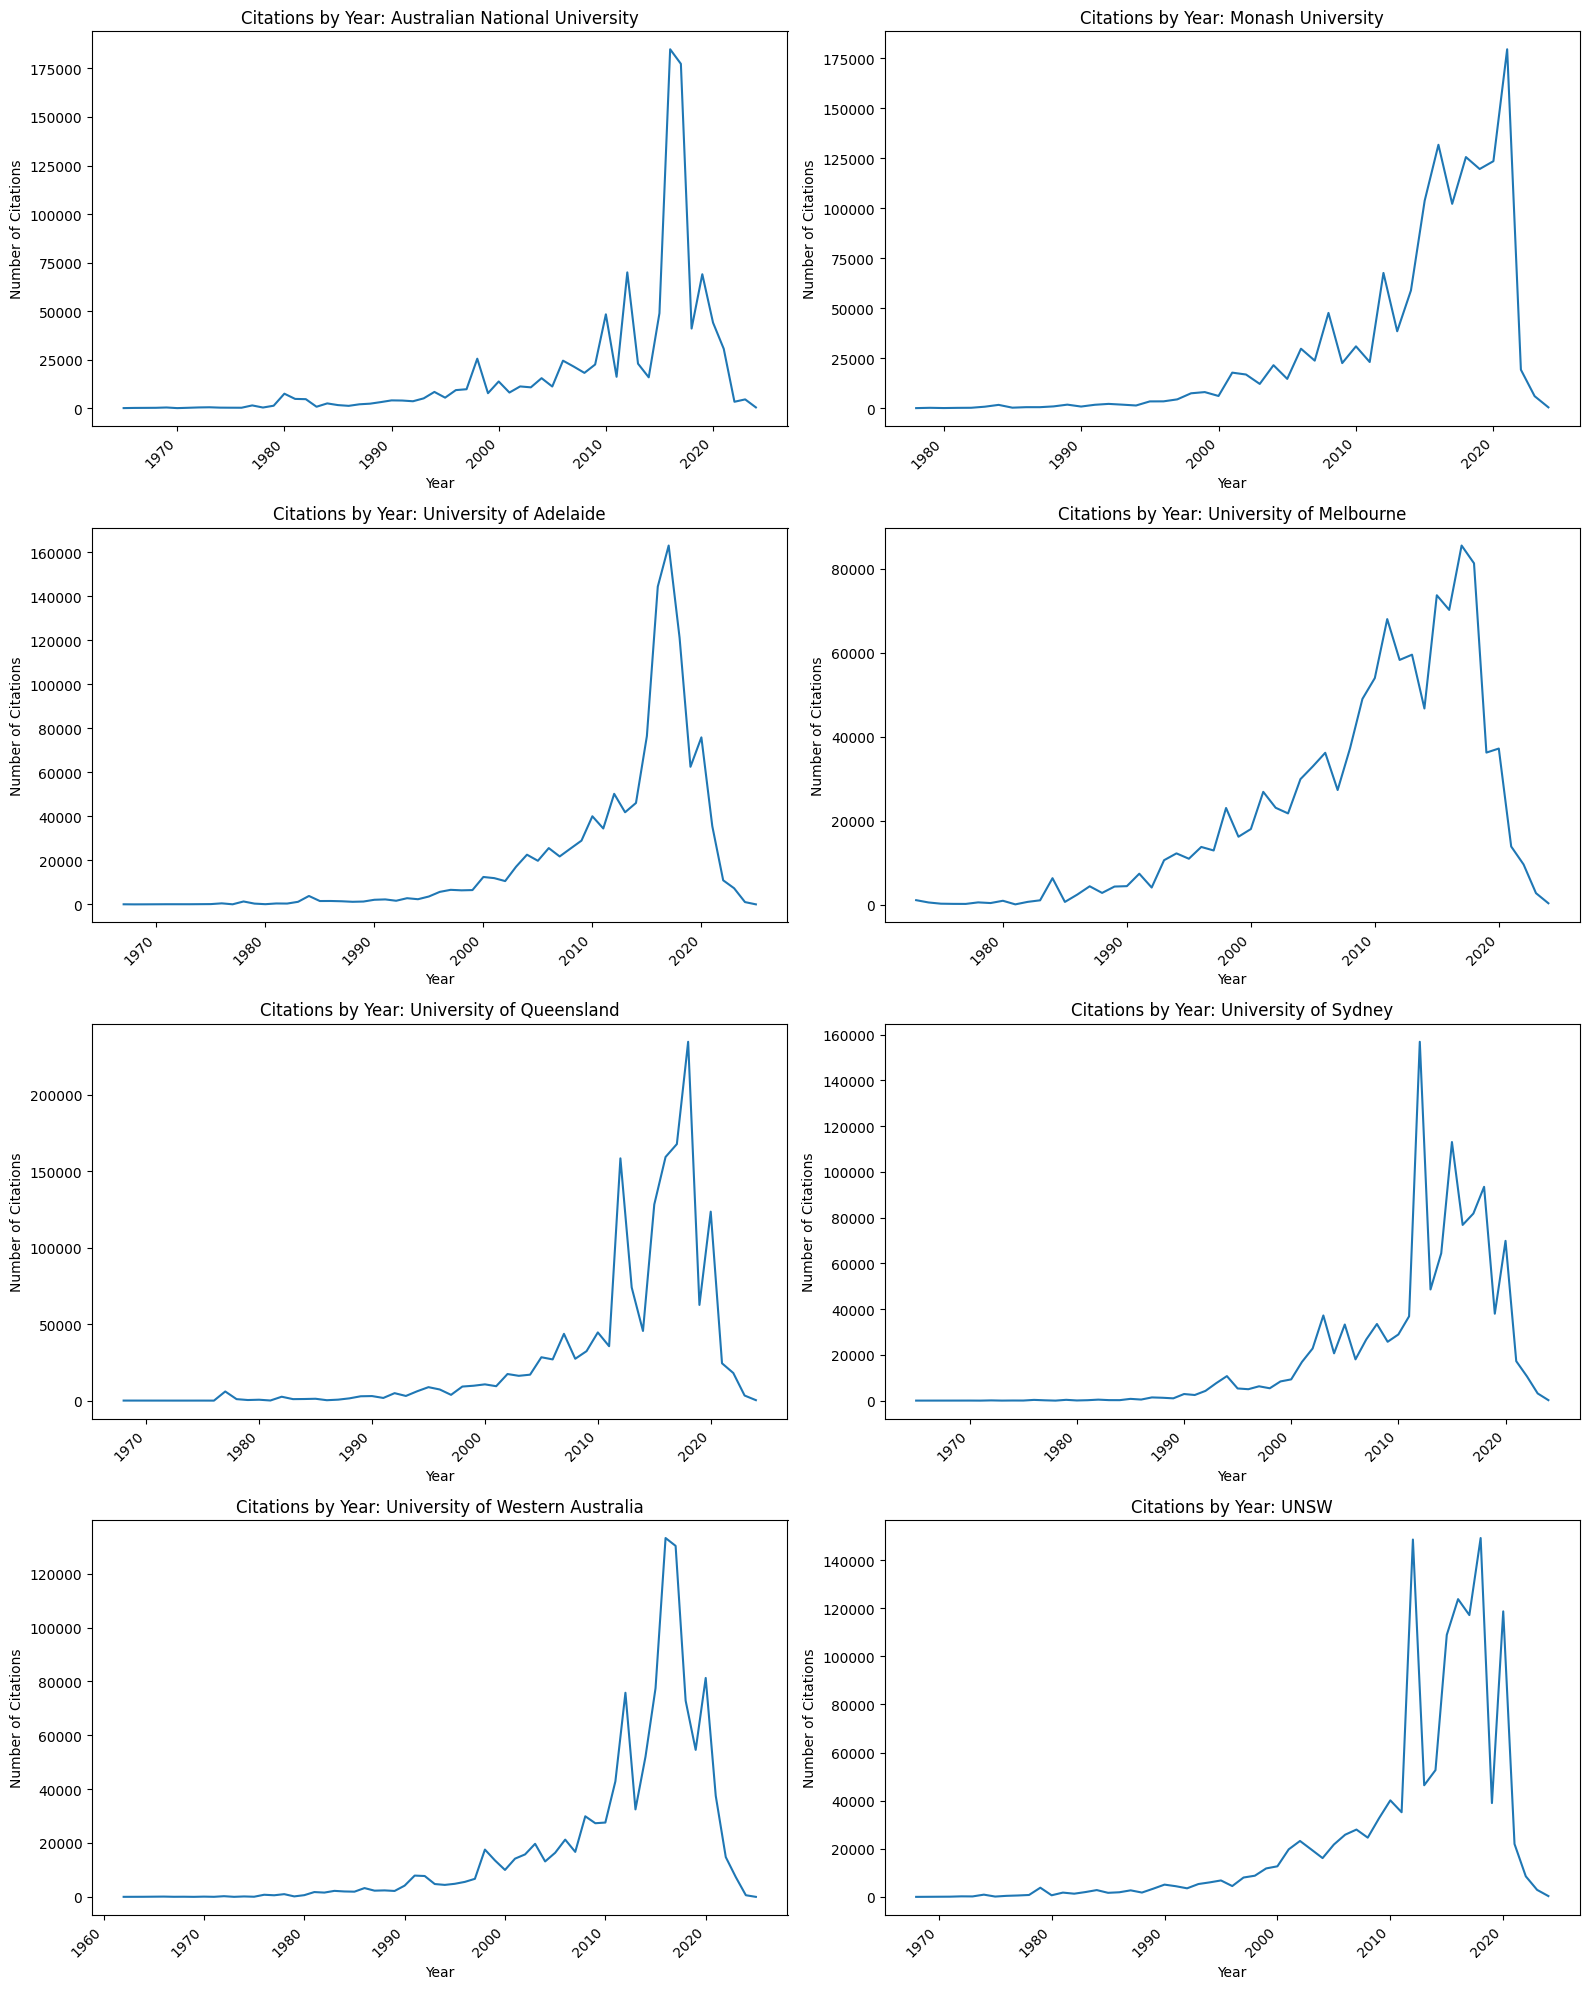

In [17]:
def citations_over_time(author_data, save=None, exclude_years=[]):
    def citations_by_year(author_data, university):
        citations = []
        for author in author_data[university]:
            for pub in author['publications']:
                year = int(pub['cover_date'].split('-')[0])
                if year in exclude_years:
                    continue
                citations.append({'University': university, 'Year': year, 'Citation Count': pub['citations']})

        df = pd.DataFrame(citations)
        df = df.groupby(['University', 'Year']).sum().reset_index().sort_values(['University', 'Year'])
        return df

    universities = list(author_data.keys())[:8]
    aggregate_df = pd.concat([citations_by_year(author_data, university) for university in universities])

    plt.figure(figsize=(12, 8))
    sns.lineplot(x='Year', y='Citation Count', hue='University', data=aggregate_df, palette='muted')
    plt.xlabel('Year')
    plt.ylabel('Number of Citations')
    plt.title('Citations by Year across 8 Universities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 20))
    for i, university in enumerate(universities):
        plt.subplot(4, 2, i+1)
        citations_df = citations_by_year(author_data, university)

        sns.lineplot(x='Year', y='Citation Count', data=citations_df, ax=plt.gca())
        plt.xlabel('Year')
        plt.ylabel('Number of Citations')
        plt.title(f'Citations by Year: {university}')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig(save)

citations_over_time(author_data)

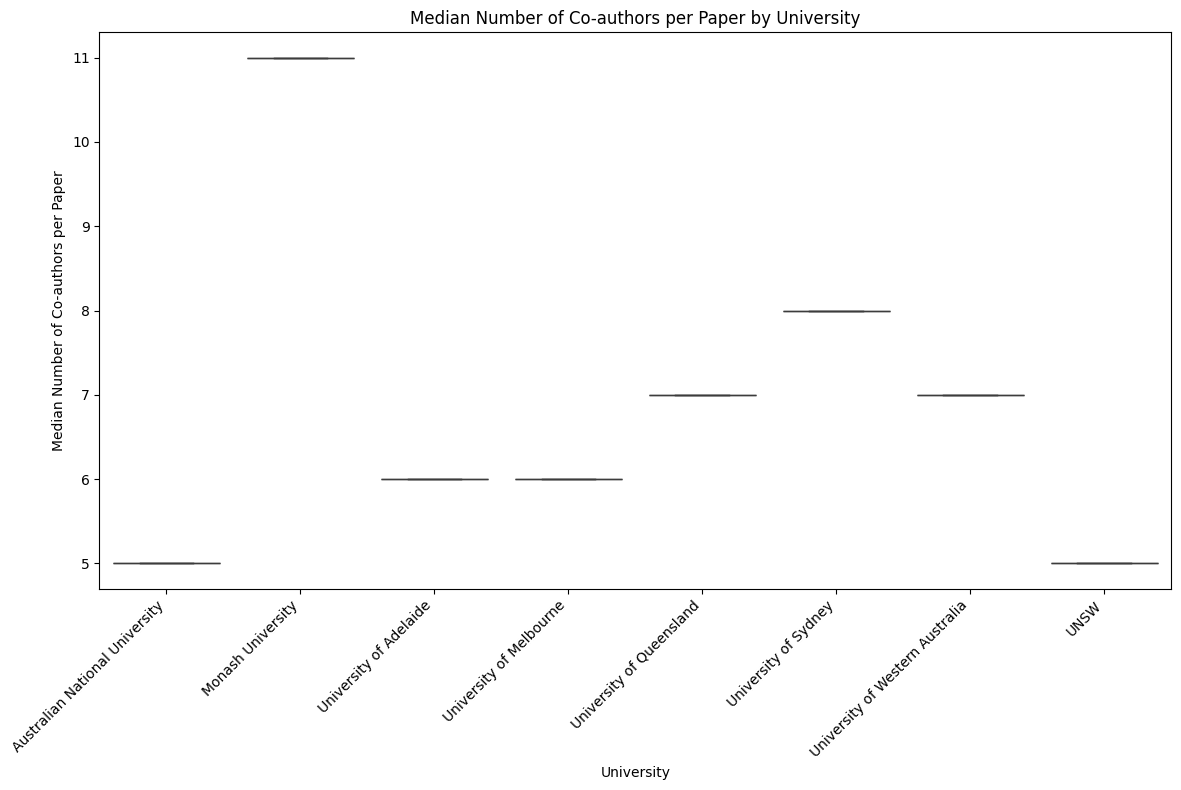

In [31]:
# Function to calculate median number of co-authors per paper by university
def median_coauthors_by_university(author_data):
    coauthors_data = []
    for affiliation, authors in author_data.items():
        coauthor_counts = []
        for author in authors:
            coauthor_counts.extend(len(pub['authors']) for pub in author['publications'])
        coauthors_data.append({
            'University': affiliation,
            'Median Co-authors': np.median(coauthor_counts)
        })
    coauthors_df = pd.DataFrame(coauthors_data)
    return coauthors_df

median_coauthors_df = median_coauthors_by_university(author_data)

# Plotting using Seaborn (box plot)
plt.figure(figsize=(12, 8))
sns.boxplot(x='University', y='Median Co-authors', hue='University', legend=False, data=median_coauthors_df, palette='muted')
plt.xlabel('University')
plt.ylabel('Median Number of Co-authors per Paper')
plt.title('Median Number of Co-authors per Paper by University')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

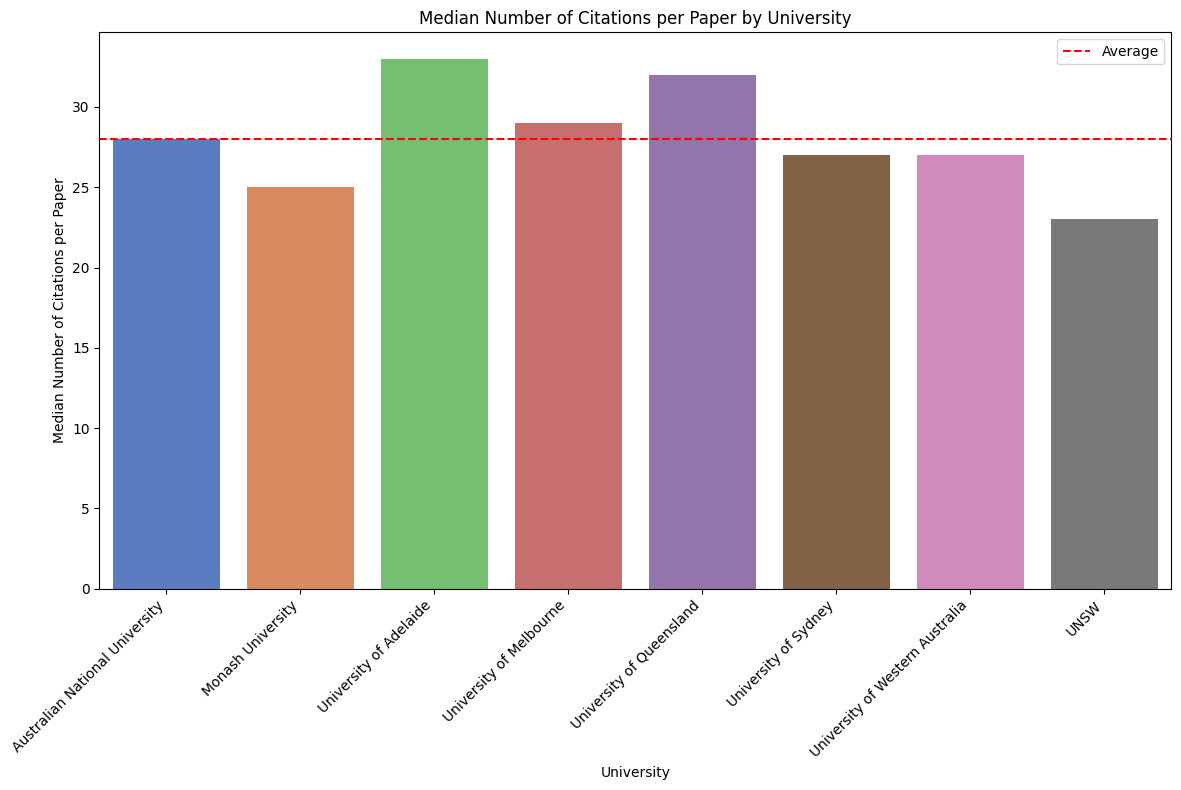

In [20]:
# Function to calculate median number of citations per paper by university
def median_citations_per_paper(author_data):
    citations_data = []
    for affiliation, authors in author_data.items():
        citations_per_paper = []
        for author in authors:
            for pub in author['publications']:
                citations_per_paper.append(pub['citations'])
        citations_data.append({
            'University': affiliation,
            'Median Citations per Paper': np.median(citations_per_paper)
        })
    citations_df = pd.DataFrame(citations_data)
    return citations_df

citations_df = median_citations_per_paper(author_data)

# Plotting using Seaborn (box plot)
plt.figure(figsize=(12, 8))
sns.barplot(x='University', y='Median Citations per Paper', hue='University', legend=False, data=citations_df, palette='muted')
plt.axhline(y=citations_df['Median Citations per Paper'].mean(), color='r', linestyle='--', label='Average')
plt.legend()
plt.xlabel('University')
plt.ylabel('Median Number of Citations per Paper')
plt.title('Median Number of Citations per Paper by University')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

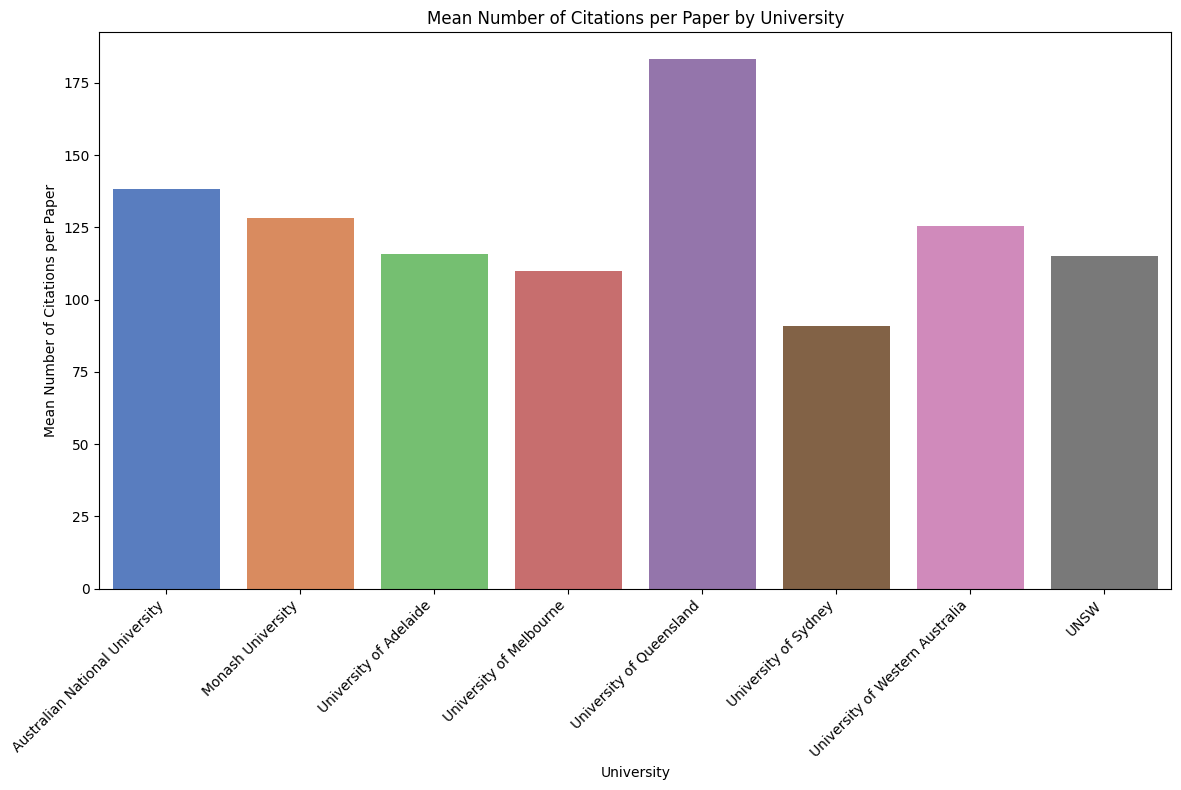

In [46]:
def mean_citations_per_paper(author_data):
    citations_data = []
    for affiliation, authors in author_data.items():
        citations_per_paper = []
        for author in authors:
            for pub in author['publications']:
                citations_per_paper.append(pub['citations'])
        citations_data.append({
            'University': affiliation,
            'Mean Citations per Paper': np.mean(citations_per_paper)
        })
    citations_df = pd.DataFrame(citations_data)
    return citations_df

mean_citations_df = mean_citations_per_paper(author_data)

# Plotting using Seaborn (bar plot)
plt.figure(figsize=(12, 8))
sns.barplot(x='University', y='Mean Citations per Paper', hue='University', label=False, data=mean_citations_df, palette='muted')

plt.xlabel('University')
plt.ylabel('Mean Number of Citations per Paper')
plt.title('Mean Number of Citations per Paper by University')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

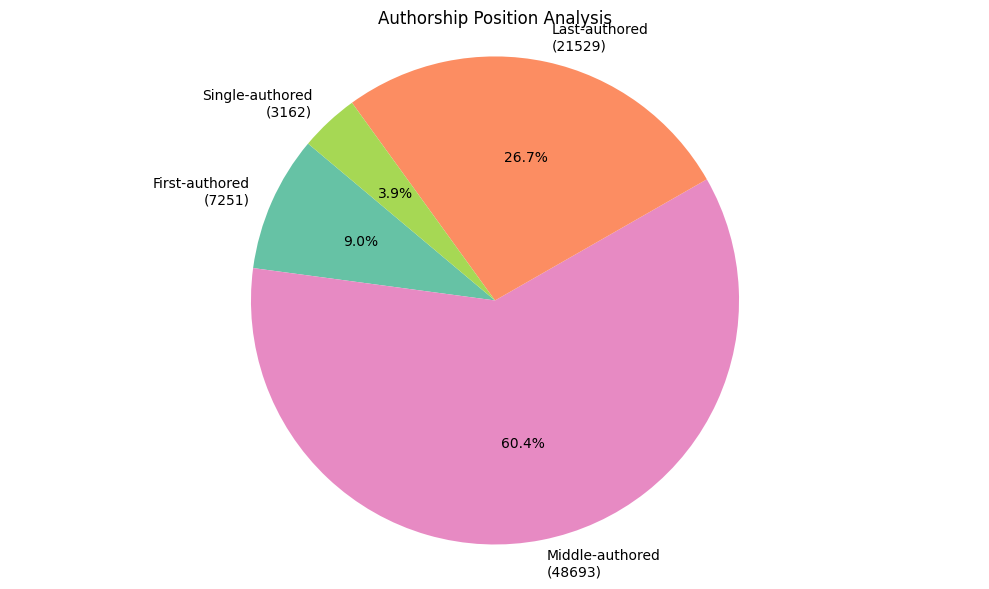

In [38]:
# NOTE: Needs to include middle authored count as well
def authorship_position_analysis(author_data):
    position_data = []
    for affiliation, authors in author_data.items():
        first_count = 0
        middle_count = 0
        last_count = 0
        single_count = 0
        for author in authors:
            for pub in author['publications']:
                if len(pub['authors']) == 1:
                    single_count += 1
                elif pub['authors'][0]['scopus_id'] == author['scopus_id']:
                    first_count += 1
                elif pub['authors'][-1]['scopus_id'] == author['scopus_id']:
                    last_count += 1
                else:
                    middle_count += 1
        total_papers = first_count + middle_count + last_count + single_count
        if total_papers > 0:
            position_data.append({
                'University': affiliation,
                'First-authored (%)': (first_count / total_papers) * 100,
                'Middle-authored (%)': (middle_count / total_papers) * 100,
                'Last-authored (%)': (last_count / total_papers) * 100,
                'Single-authored (%)': (single_count / total_papers) * 100,
                'First-authored': first_count,
                'Middle-authored': middle_count,
                'Last-authored': last_count,
                'Single-authored': single_count
            })
    position_df = pd.DataFrame(position_data)
    return position_df

# Example usage:
position_df = authorship_position_analysis(author_data)

# Plotting using Matplotlib (pie chart)
plt.figure(figsize=(10, 6))
labels = ['First-authored\n({})'.format(position_df['First-authored'].sum().round(1)),
          'Middle-authored\n({})'.format(position_df['Middle-authored'].sum().round(1)),
          'Last-authored\n({})'.format(position_df['Last-authored'].sum().round(1)),
          'Single-authored\n({})'.format(position_df['Single-authored'].sum().round(1))]
sizes = [position_df['First-authored'].sum(),
         position_df['Middle-authored'].sum(),
         position_df['Last-authored'].sum(),
         position_df['Single-authored'].sum()]
colors = ['#66c2a5', '#e78ac3', '#fc8d62', '#a6d854']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Authorship Position Analysis')
plt.axis('equal')
plt.tight_layout()
plt.show()


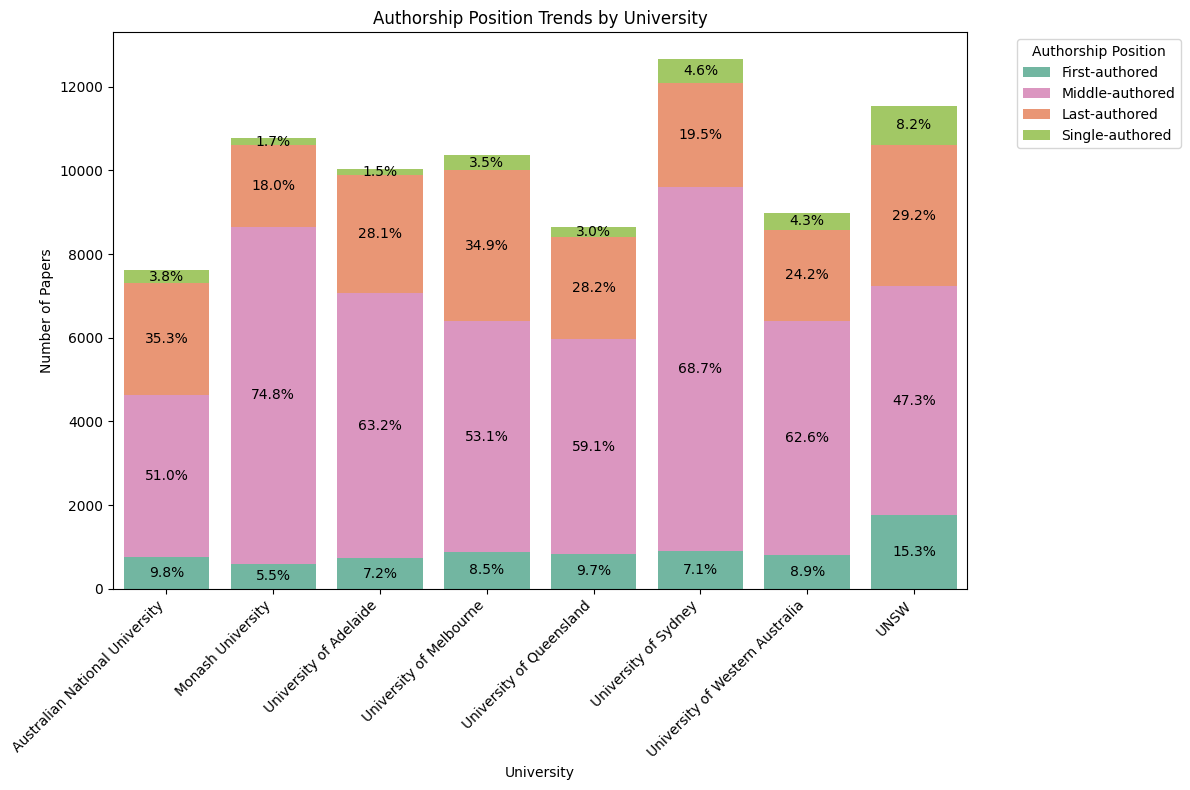

In [42]:
# NOTE: Needs to include middle authored count as well
# Function to calculate trends in authorship positions
def authorship_position_trends(author_data):
    trends_data = []
    for affiliation, authors in author_data.items():
        first_counts = []
        middle_counts = []
        last_counts = []
        single_counts = []
        for author in authors:
            first_count = 0
            middle_count = 0
            last_count = 0
            single_count = 0
            for pub in author['publications']:
                if len(pub['authors']) == 1:
                    single_count += 1
                elif pub['authors'][0]['scopus_id'] == author['scopus_id']:
                    first_count += 1
                elif pub['authors'][-1]['scopus_id'] == author['scopus_id']:
                    last_count += 1
                else:
                    middle_count += 1
            first_counts.append(first_count)
            middle_counts.append(middle_count)
            last_counts.append(last_count)
            single_counts.append(single_count)
        total_papers = np.sum(first_counts) + np.sum(middle_counts) + np.sum(last_counts) + np.sum(single_counts)
        if total_papers > 0:
            trends_data.append({
                'University': affiliation,
                'First-authored': np.sum(first_counts),
                'Middle-authored': np.sum(middle_counts),
                'Last-authored': np.sum(last_counts),
                'Single-authored': np.sum(single_counts),
                'First-authored (%)': (np.sum(first_counts) / total_papers) * 100,
                'Middle-authored (%)': (np.sum(middle_counts) / total_papers) * 100,
                'Last-authored (%)': (np.sum(last_counts) / total_papers) * 100,
                'Single-authored (%)': (np.sum(single_counts) / total_papers) * 100
            })
    trends_df = pd.DataFrame(trends_data)
    return trends_df

# Example usage:
trends_df = authorship_position_trends(author_data)

# Plotting using Seaborn (stacked bar chart)
plt.figure(figsize=(12, 8))
# ['#66c2a5', '#e78ac3', '#fc8d62', '#a6d854']
sns.barplot(x='University', y='First-authored', data=trends_df, color='#66c2a5', label='First-authored')
sns.barplot(x='University', y='Middle-authored', data=trends_df, bottom=trends_df['First-authored'], color='#e78ac3', label='Middle-authored')
sns.barplot(x='University', y='Last-authored', data=trends_df, bottom=trends_df['First-authored'] + trends_df['Middle-authored'], color='#fc8d62', label='Last-authored')
sns.barplot(x='University', y='Single-authored', data=trends_df, bottom=trends_df['First-authored'] + trends_df['Middle-authored'] + trends_df['Last-authored'], color='#a6d854', label='Single-authored')
plt.xlabel('University')
plt.ylabel('Number of Papers')
plt.title('Authorship Position Trends by University')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Authorship Position', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentages as labels
for index, row in trends_df.iterrows():
    plt.text(index, row['First-authored'] / 2, f"{row['First-authored (%)']:.1f}%", ha='center', va='center')
    plt.text(index, row['First-authored'] + row['Middle-authored'] / 2, f"{row['Middle-authored (%)']:.1f}%", ha='center', va='center')
    plt.text(index, row['First-authored'] + row['Middle-authored'] + row['Last-authored'] / 2, f"{row['Last-authored (%)']:.1f}%", ha='center', va='center')
    plt.text(index, row['First-authored'] + row['Middle-authored'] + row['Last-authored'] + row['Single-authored'] / 2, f"{row['Single-authored (%)']:.1f}%", ha='center', va='center')

plt.tight_layout()
plt.show()

In [ ]:
%pip install geopandas

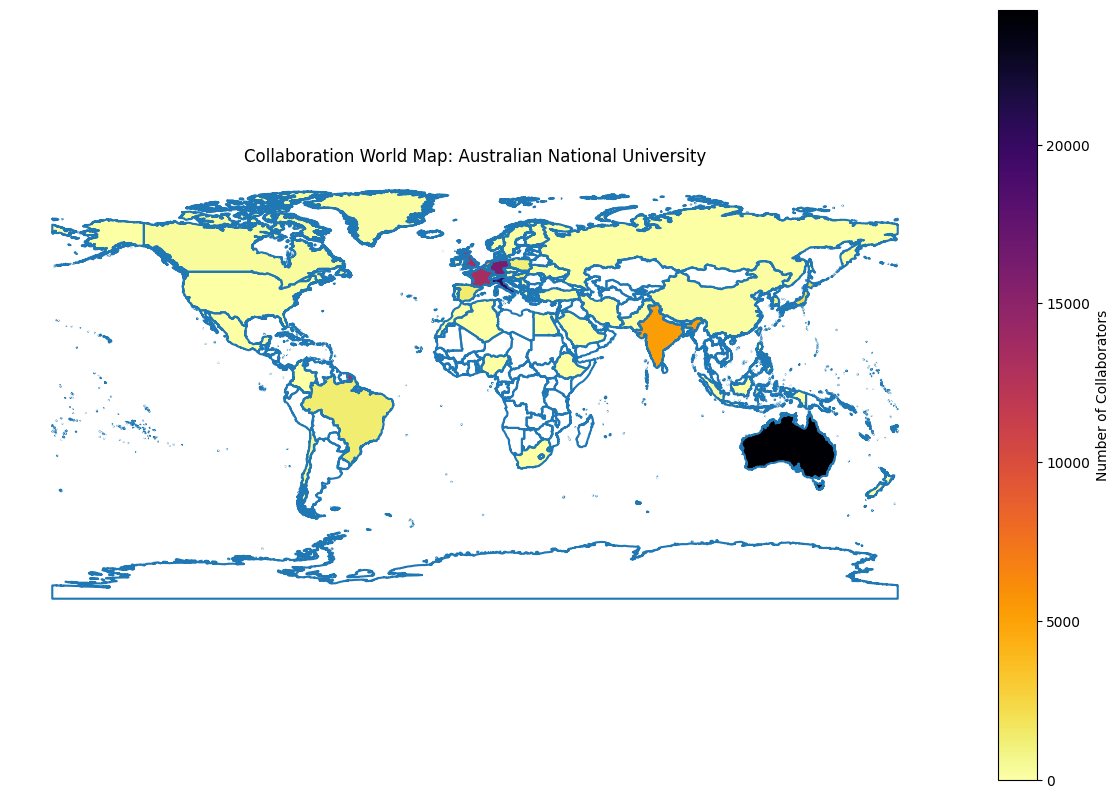

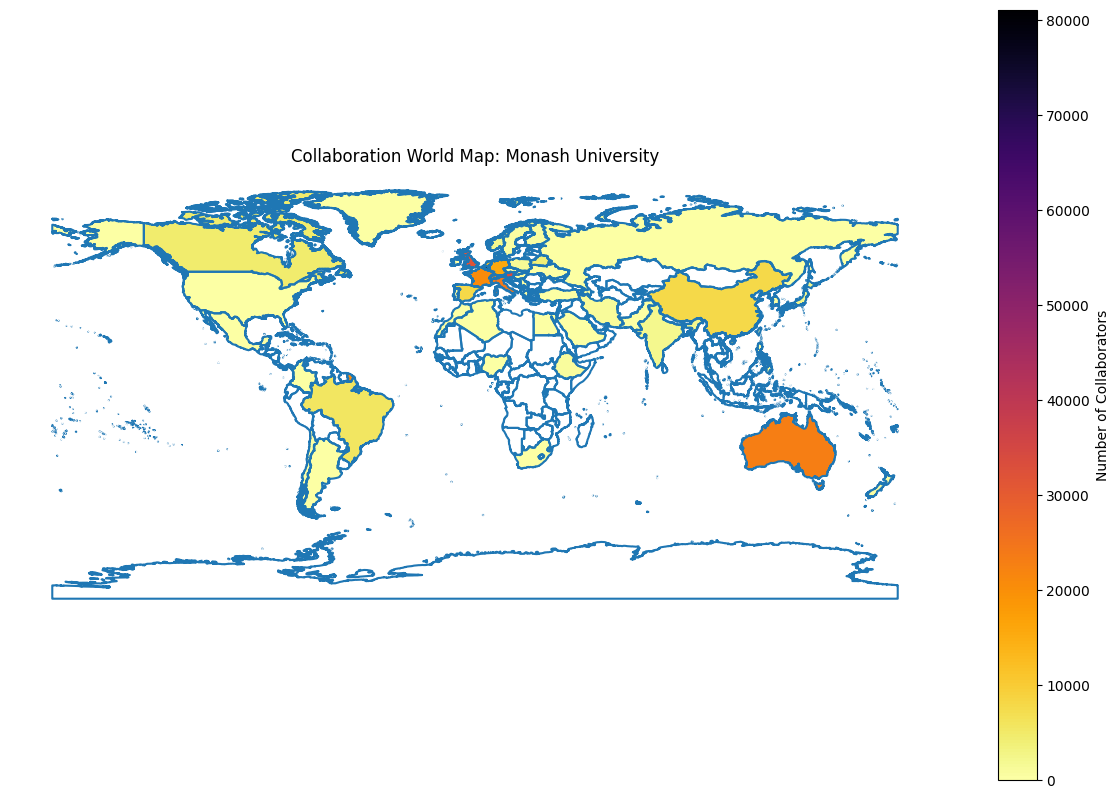

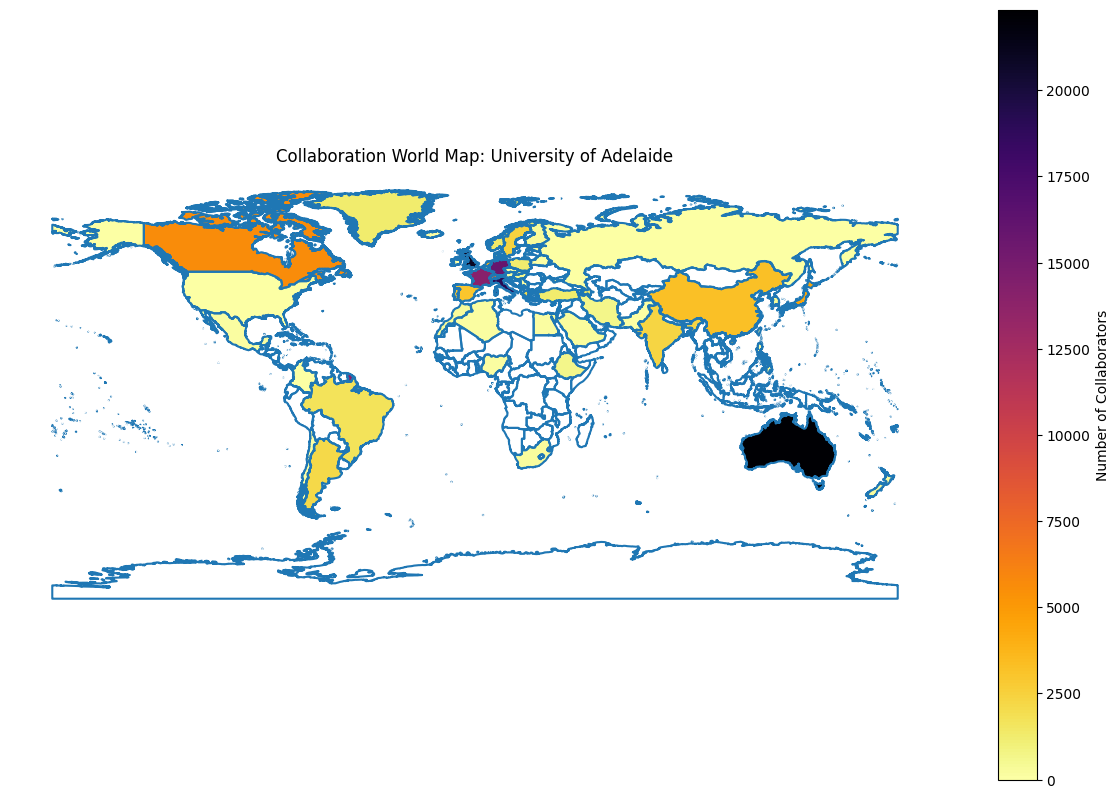

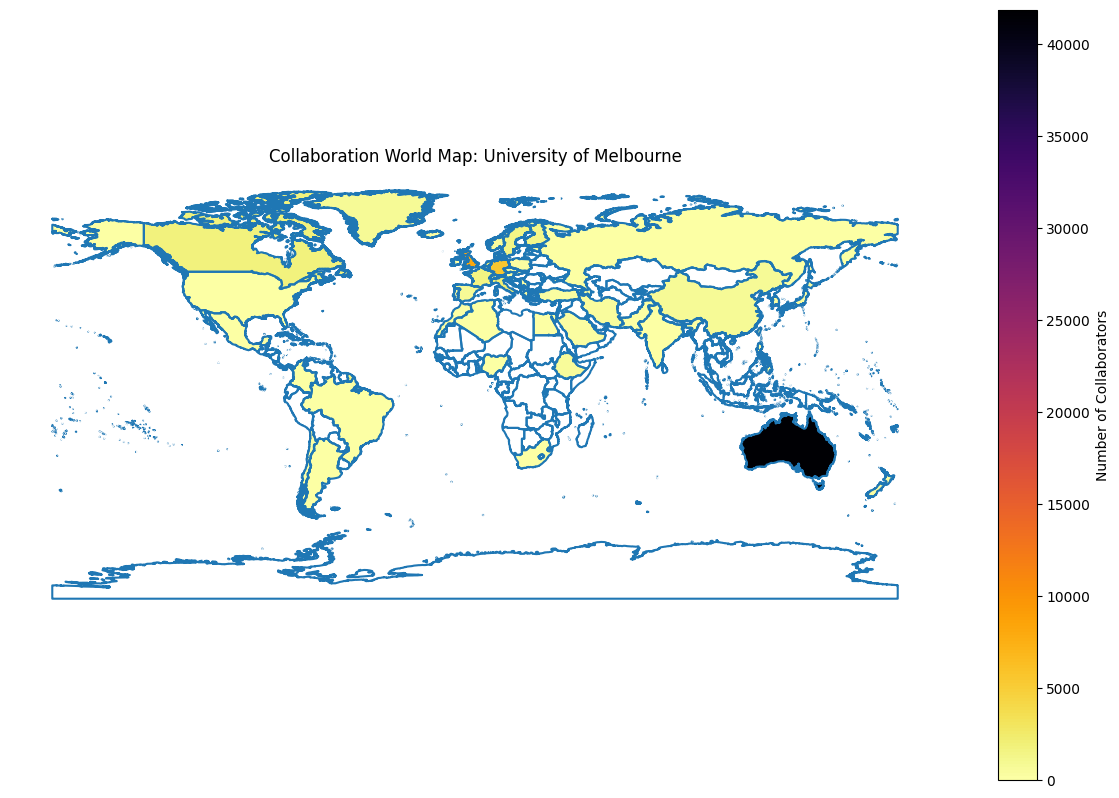

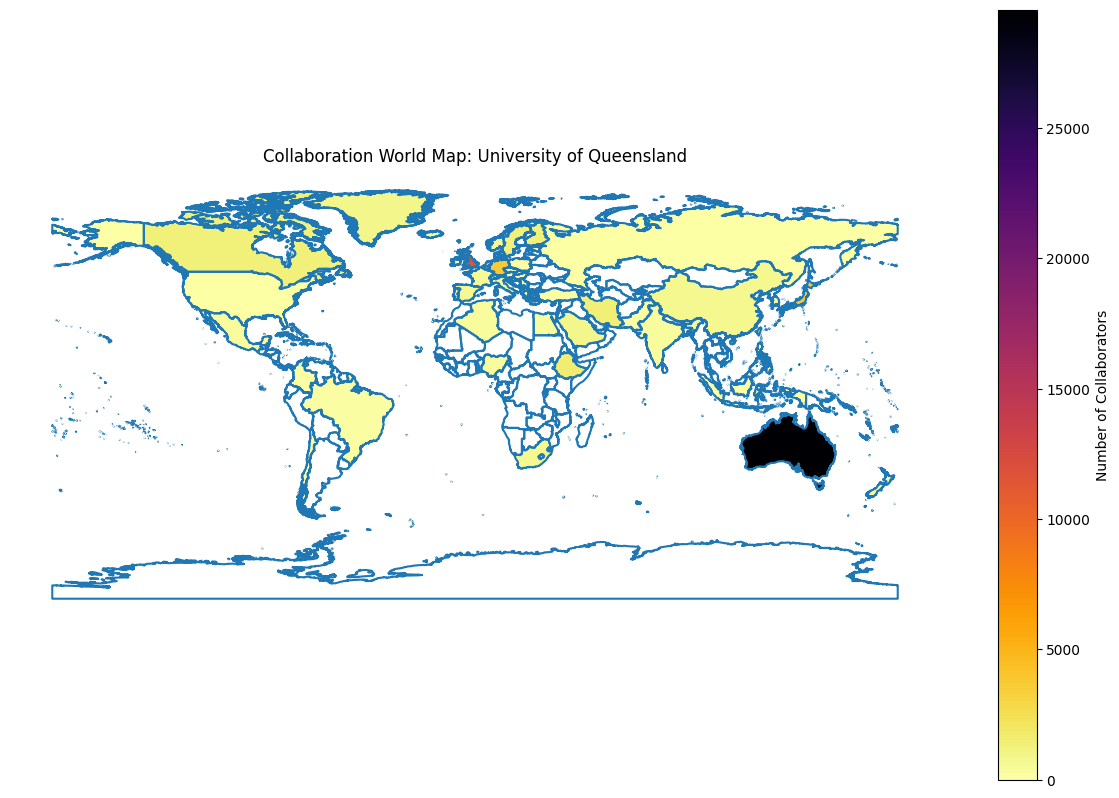

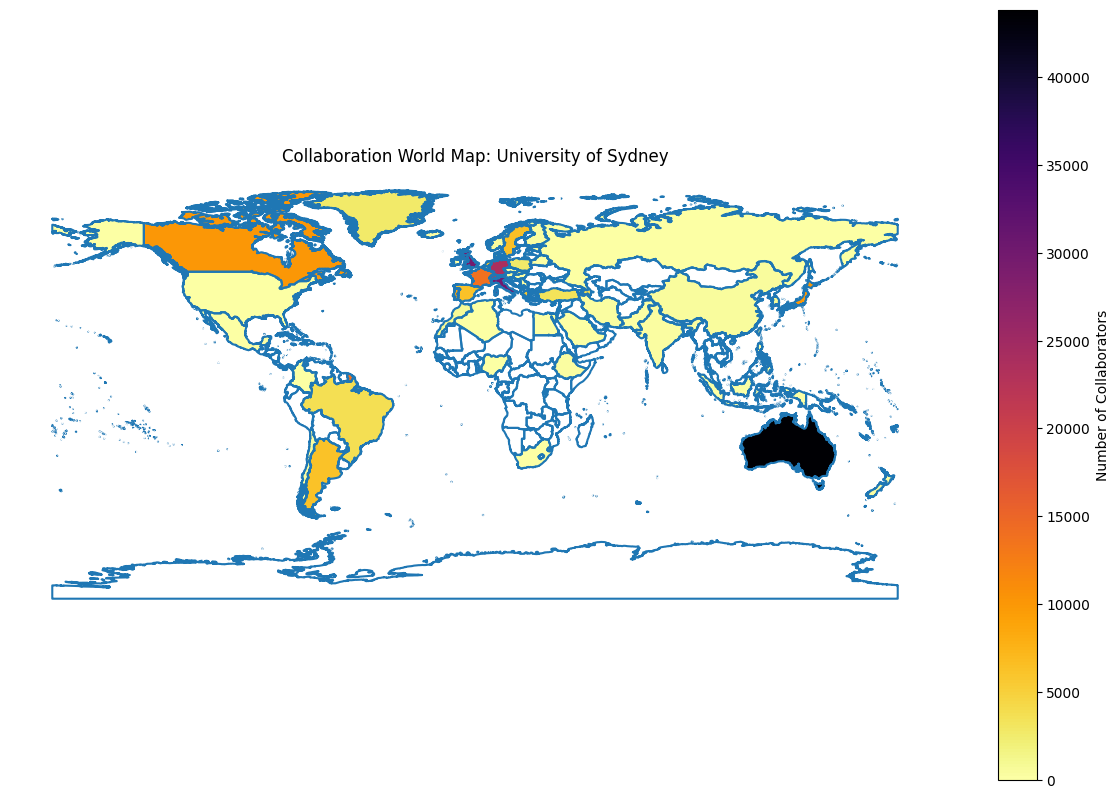

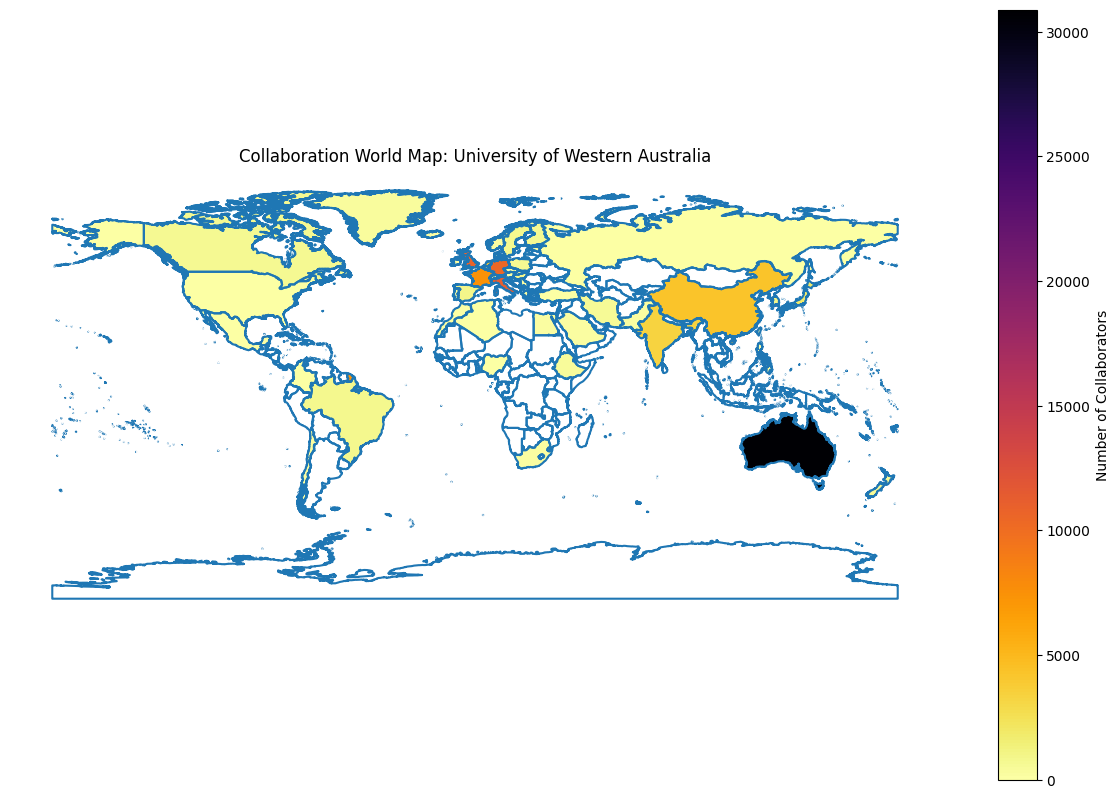

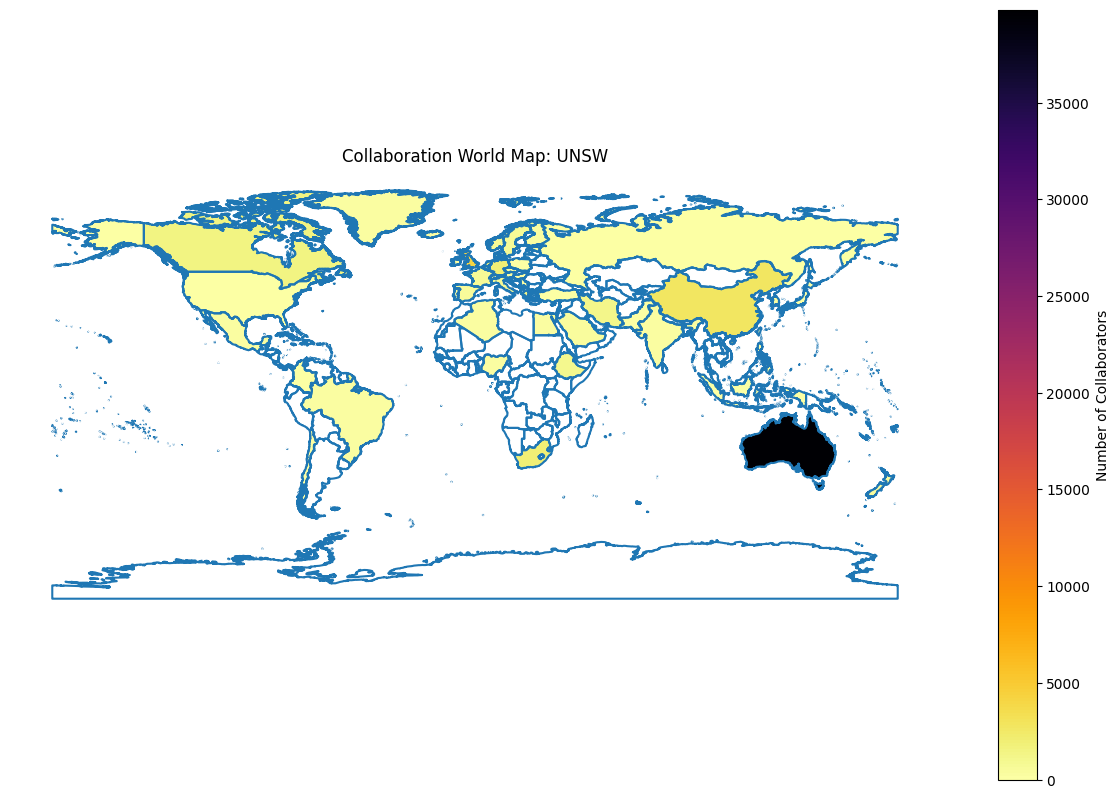

In [15]:
from scopus import affiliation_scopus_details

import geopandas as gpd
import matplotlib.pyplot as plt

"""
Data for territories was sourced from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/
It identifies multiple territories differently, kindly read their documentation for more information.

Territories missing: Hong Kong SAR, Macau SAR, Palestine
"""
 # Data for geographies is stored under incorrect names in the world dataframe
replace_countries = {
    'United States': 'United States of America',
    'Russian Federation': 'Russia',
    'Serbia': 'Republic of Serbia',
    'Czech Republic': 'Czechia',
    'Hong Kong': 'China'
}
# Contains all countries in the world
world = gpd.read_file("ne_10m_admin_0_sovereignty.zip")

def plot_choropleth_worldmap(countries, title, save=None):
    for country in set(countries):
        if country in replace_countries:
            country = replace_countries[country]
        # Create a new column called count which contains count of each country
        world.loc[world['SOVEREIGNT'] == country, 'count'] = countries.count(country)
        # Print countries not present in the world dataframe
        # if world.loc[world['SOVEREIGNT'] == country].empty:
        #     print(f"Country not found: {country}")

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.boundary.plot(ax=ax)
    world.plot(column='count', ax=ax, legend=True, legend_kwds={'label': "Number of Collaborators"}, cmap='inferno_r')
    if title: plt.title(title)
    ax.set_axis_off()
    plt.show()
    if save:
        plt.savefig(save)
    world.drop(columns=['count'], inplace=True)

def plot_collaboration_world_map(author_data, institution_data, save=None):
    def plot_collaboration_data(author_data, university):
        countries = []
        for author in author_data[university]:
            for pub in author['publications']:
                for coauthor in pub['authors']:
                    coauthor_primary_affiliation = coauthor['affiliation_id'][0] if coauthor['affiliation_id'] else None
                    if coauthor_primary_affiliation in affiliation_scopus_details:
                        country = affiliation_scopus_details[coauthor_primary_affiliation]['country']
                        countries.append(country)
        
        plot_choropleth_worldmap(countries, f'Collaboration World Map: {university}', save)

    for university in author_data.keys():
        plot_collaboration_data(author_data, university)

plot_collaboration_world_map(author_data, institution_data)

In [31]:
def comparison_metrics(author_data):
    metrics_data = []
    for affiliation, authors in author_data.items():
        total_citations = 0
        total_publications = 0
        citations_per_paper = []
        for author in authors:
            total_citations += sum(pub['citations'] for pub in author['publications'])
            total_publications += len(author['publications'])
            citations_per_paper.extend(pub['citations'] for pub in author['publications'])
        metrics_data.append({
            'University': affiliation,
            'Total Citations': total_citations,
            'Total Publications': total_publications,
            'Median Citations per Paper': np.median(citations_per_paper) if citations_per_paper else 0
        })
    metrics_df = pd.DataFrame(metrics_data)
    return metrics_df

metrics_df = comparison_metrics(author_data)
metrics_df

University  Total Citations  Total Publications  \
0   Australian National University          1053002                7607   
1                Monash University          1382643               10779   
2           University of Adelaide          1161874               10039   
3          University of Melbourne          1139672               10368   
4         University of Queensland          1587143                8657   
5             University of Sydney          1149162               12665   
6  University of Western Australia          1125995                8973   
7                             UNSW          1329942               11547   

   Median Citations per Paper  
0                        28.0  
1                        25.0  
2                        33.0  
3                        29.0  
4                        32.0  
5                        27.0  
6                        27.0  
7                        23.0